## Game space
- The game_space figure in the Method part, plotting several classic games within this two-dimensional space as an example.

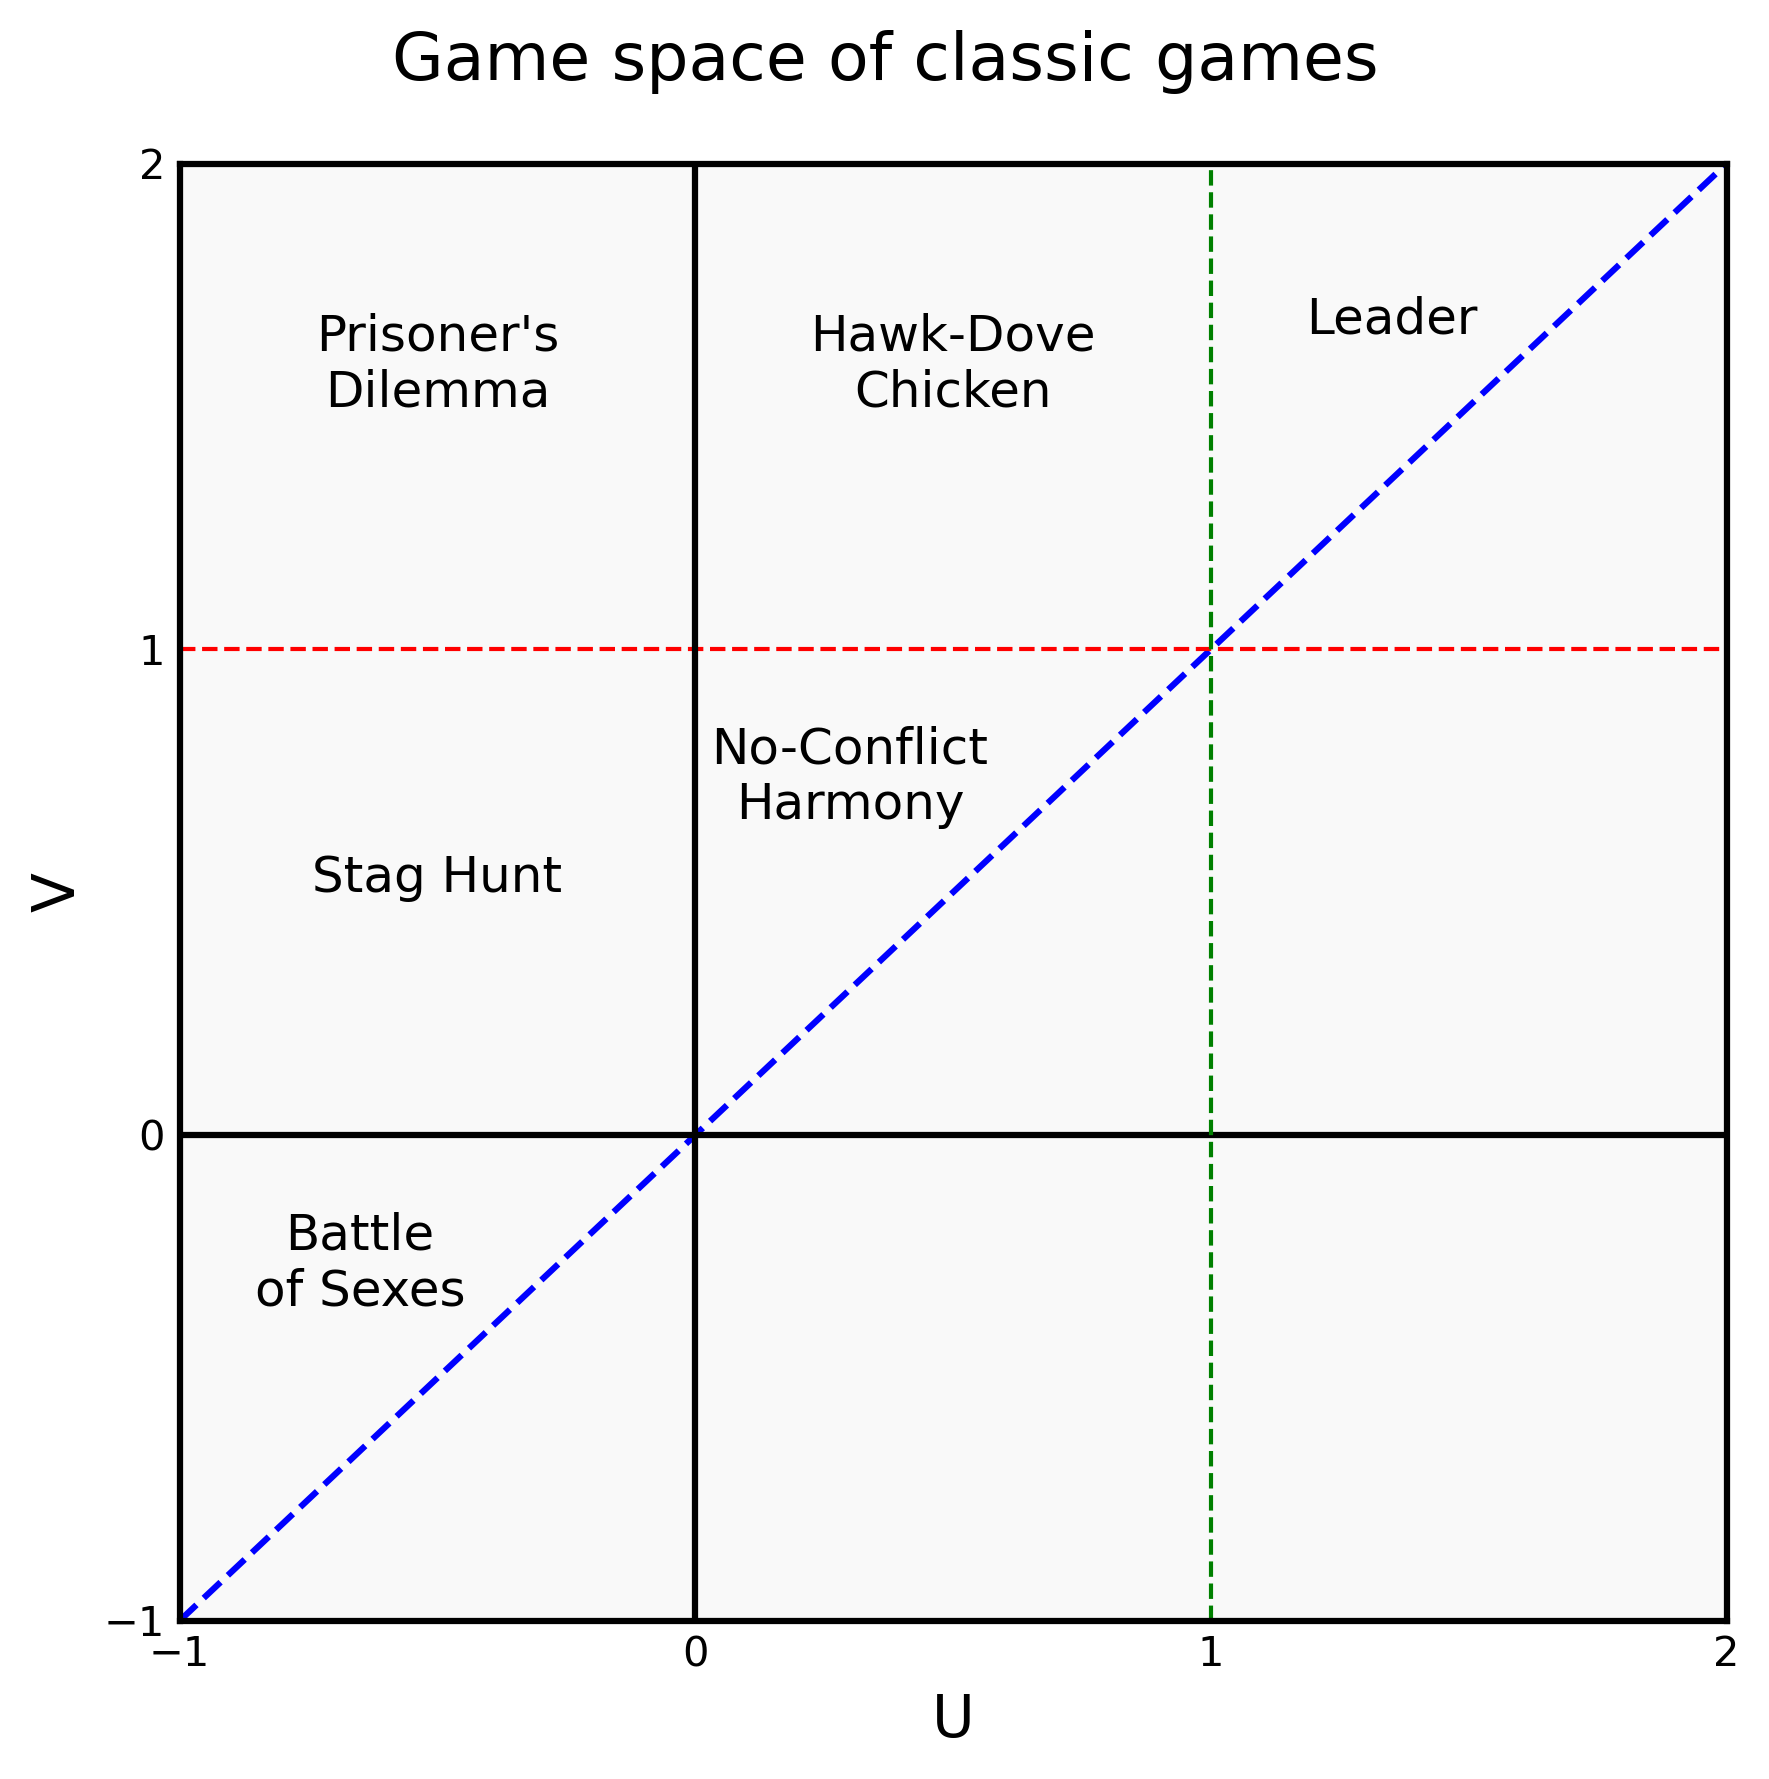

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)

b = np.linspace(-1, 2, 1000)
c = b
ax.plot(b, c, 'blue', linestyle='--', linewidth=1.5)

ax.axhline(y=0, color='black', linewidth=1.5)
ax.axhline(y=1, color='red', linewidth=1, linestyle='--')
ax.axvline(x=0, color='black', linewidth=1.5)
ax.axvline(x=1, color='green', linewidth=1, linestyle='--')

ax.set_xlabel('U', fontsize=14)
ax.set_ylabel('V', fontsize=14)

ax.text(-0.5, 1.5, '\nPrisoner\'s\nDilemma', fontsize=12, ha='center')
ax.text(0.5, 1.5, '\nHawk-Dove\nChicken', fontsize=12, ha='center')
ax.text(1.35, 1.65, '\nLeader', fontsize=12, ha='center')
ax.text(-0.5, 0.5, '\nStag Hunt', fontsize=12, ha='center')
ax.text(0.3, 0.65, '\nNo-Conflict\nHarmony', fontsize=12, ha='center')
ax.text(-0.65, -0.35, '\nBattle\nof Sexes', fontsize=12, ha='center')
ax.tick_params(axis='both', which='both', length=0)

ax.set_xticks([-1, 0, 1, 2])
ax.set_yticks([-1, 0, 1, 2])

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

ax.set_facecolor('#f9f9f9')
plt.suptitle("Game space of classic games", fontsize=16)
plt.tight_layout()
plt.savefig('Figure/game_space.png', dpi=300, bbox_inches='tight')

## Inequality

In [1]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import scipy.stats as stats
import seaborn as sns

In [2]:
def plot_ccd_and_fit(data_dir,steps=[90],fit_step=90,col="Wealth",outname="Figure/ccd_and_fit.png",xmin_auto=True):
    file_pattern = os.path.join(data_dir, "agent_data_*.csv")
    all_files = sorted(glob.glob(file_pattern))

    all_step_data = {step: [] for step in steps}
    all_fit_data = []

    for fpath in all_files:
        df = pd.read_csv(fpath)
        for step in steps:
            vals = df[df["Step"] == step][col].values
            vals = vals[~np.isnan(vals)]
            all_step_data[step].extend(vals)
        vals_fit = df[df["Step"] == fit_step][col].values
        vals_fit = vals_fit[~np.isnan(vals_fit)]
        vals_fit = vals_fit[vals_fit > 0]
        all_fit_data.extend(vals_fit)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
    for i, step in enumerate(steps):
        data = np.sort(np.array(all_step_data[step]))
        y = 1.0 - np.arange(len(data)) / len(data)
        axes[0].step(data, y, where='post', lw=2, color=colors[i], label=f"Step {step}")
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlabel("Wealth", fontsize=14)
    axes[0].set_ylabel("CCD", fontsize=14)
    axes[0].set_title("Wealth Distribution", fontsize=16)
    axes[0].legend(fontsize=12)

    data_fit = np.array(all_fit_data)
    fit = powerlaw.Fit(data_fit, xmin=None if xmin_auto else min(data_fit), verbose=False)
    print(f"Estimated alpha: {fit.alpha:.2f}")
    print(f"Estimated xmin: {fit.xmin:.2f}")
    ax = axes[1]
    fit.plot_ccdf(ax=ax, linewidth=2, color="b", label="Data")
    fit.power_law.plot_ccdf(ax=ax, color="r", linestyle="--", label="Power Law Fit")
    fit.lognormal.plot_ccdf(ax=ax, color="g", linestyle=":", label="Lognormal Fit")
    fit.exponential.plot_ccdf(ax=ax, color="m", linestyle="-.", label="Exponential Fit")
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlabel("Wealth", fontsize=14)
    ax.set_title(f"Step {fit_step} Distribution Fit", fontsize=16)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)

    params = stats.lognorm.fit(all_fit_data)
    D, p = stats.kstest(data, 'lognorm', params)
    print(f"KS statistic: {D:.4f}, p-value: {p:.4g}")

    params = stats.expon.fit(all_fit_data)
    D, p = stats.kstest(data, 'expon', params)
    print(f"Exponential KS statistic: {D:.4f}, p-value: {p:.4g}")

    R, p = fit.distribution_compare('power_law', 'lognormal')
    R2, p2 = fit.distribution_compare('power_law', 'exponential')
    print(f"Power Law vs Lognormal: R={R:.3f}, p={p:.3g}")
    print(f"Power Law vs Exponential: R={R2:.3f}, p={p2:.3g}")

Estimated alpha: 8.24
Estimated xmin: 231.80
KS statistic: 0.0391, p-value: 0.004308
Exponential KS statistic: 0.2075, p-value: 5.001e-76
Power Law vs Lognormal: R=-4.517, p=0.0431
Power Law vs Exponential: R=-3.462, p=0.000651


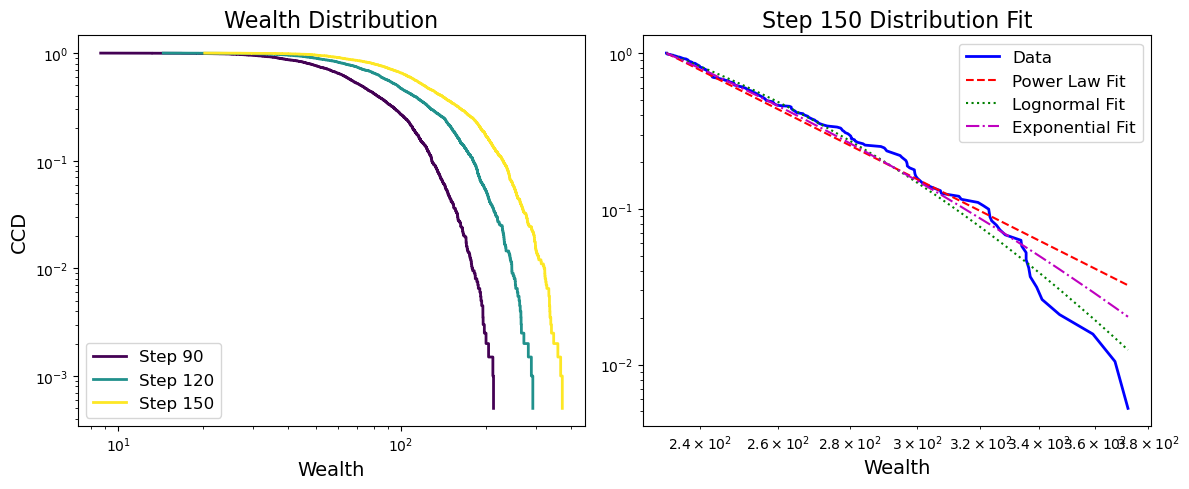

In [3]:
plot_ccd_and_fit("Data/assortativity_norm", steps=[90,120,150], fit_step=150)

In [ ]:
def plot_distribution(datafile,step=None,col="Wealth",bins=40,outname="Figure/wealth_dist.png"):
    df = pd.read_csv(datafile)
    if step is None:
        step = df["Step"].max()
    data = df[df["Step"] == step][col].values
    data = data[~np.isnan(data)]

    plt.figure(figsize=(8,5))
    sns.histplot(data, bins=bins, kde=True, color="tab:blue", stat="density", alpha=0.6)
    plt.title(f"Distribution of Wealth (Step {step})", fontsize=16)
    plt.xlabel("Wealth", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)

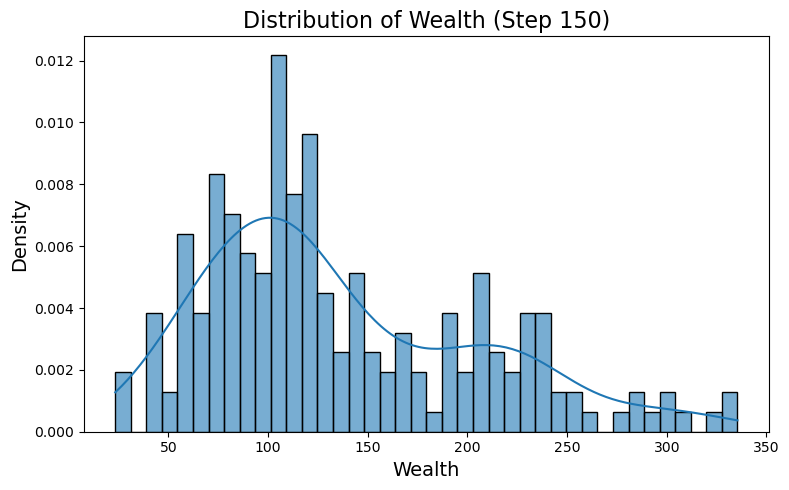

In [ ]:
plot_distribution("Data/assortativity_norm/agent_data_2025-07-10_04-35.csv", step=150)

## Default - Null model

In [6]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [7]:
def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    if x_sorted.sum() == 0:
        return 0
    return (np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted))


def load_runs(data_dir):
    file_pattern = os.path.join(data_dir, "agent_data_*.csv")
    all_files = glob.glob(file_pattern)

    runs = {
        "Null": [],
        "Default": []
    }

    for fpath in all_files:
        filename = os.path.basename(fpath)
        if "null" in filename.lower():
            runs["Null"].append(pd.read_csv(fpath))
        else:
            runs["Default"].append(pd.read_csv(fpath))
    return runs


def avg_metrics(df_list, col_rw="Recent Wealth"):
    frames = []
    for run_id, df in enumerate(df_list):
        steps, ginis, rws = [], [], []
        for step in df["Step"].unique():
            sub = df[df["Step"] == step]
            g = compute_gini(sub["Wealth"])
            rw = sub[col_rw].mean()
            steps.append(step); ginis.append(g); rws.append(rw)
        frames.append(pd.DataFrame({"Step": steps,
                                    "Gini": ginis,
                                    "RWealth": rws,
                                    "Run": run_id}))
    big = pd.concat(frames, ignore_index=True)
    agg = big.groupby("Step").agg({"Gini":  ["mean", "std", "count"],
                                   "RWealth":["mean", "std", "count"]})

    se = agg.xs("std",  level=1, axis=1) / np.sqrt(agg.xs("count", level=1, axis=1))
    mean = agg.xs("mean", level=1, axis=1)
    return mean, se


def default_null(step_max=200, data_dir="Data/gini_effect", outname="default_null_diff.png"):
    runs = load_runs(data_dir)

    null_mean, null_se = avg_metrics(runs["Null"])
    defa_mean, defa_se = avg_metrics(runs["Default"])

    steps = np.arange(step_max + 1)

    null_mean = null_mean.reindex(steps).ffill()
    defa_mean = defa_mean.reindex(steps).ffill()
    null_se = null_se.reindex(steps).ffill()
    defa_se = defa_se.reindex(steps).ffill()

    diff_mean = defa_mean - null_mean
    diff_se = np.sqrt(null_se**2 + defa_se**2)
    ci = 1.96 * diff_se

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    line1, = axes[0].plot(
        steps[5:], diff_mean["Gini"][5:], label="Mean", lw=2)
    fill1 = axes[0].fill_between(
        steps[5:],
        diff_mean["Gini"][5:] - ci["Gini"][5:],
        diff_mean["Gini"][5:] + ci["Gini"][5:],
        alpha=0.25, label="95% CI"
    )
    axes[0].set_title("Gini coefficient", fontsize=16)
    axes[0].set_ylabel("Difference in Gini", fontsize=16)
    axes[0].tick_params(axis='both', labelsize=14)

    line2, = axes[1].plot(
        steps[5:], diff_mean["RWealth"][5:], label="Mean", lw=2)
    fill2 = axes[1].fill_between(
        steps[5:],
        diff_mean["RWealth"][5:] - ci["RWealth"][5:],
        diff_mean["RWealth"][5:] + ci["RWealth"][5:],
        alpha=0.25, label="95% CI"
    )
    axes[1].set_title("Recent wealth", fontsize=16)
    axes[1].set_ylabel("Difference in Recent Wealth", fontsize=16)
    axes[1].tick_params(axis='both', labelsize=14)

    for ax in axes:
        ax.set_xlabel("Step", fontsize=16)
        ax.axhline(0, ls="--", c="grey", lw=0.7)

    fig.suptitle("Difference between default and null model", fontsize=20, y=0.98)

    axes[0].legend(fontsize=14)
    axes[1].legend(fontsize=14)

    plt.tight_layout()
    plt.savefig(outname, dpi=150)

    return diff_mean, ci

In [8]:
def extract_final_ginis(df_list):
    ginis = []
    for df in df_list:
        last_step = df["Step"].max()
        g = compute_gini(df[df["Step"] == last_step]["Wealth"])
        ginis.append(g)
    return np.array(ginis)

def gini_stat_test(data_dir):
    runs = load_runs(data_dir)
    ginis_default = extract_final_ginis(runs["Default"])
    ginis_null = extract_final_ginis(runs["Null"])

    print(f"Default mean Gini: {ginis_default.mean():.4f} ± {ginis_default.std(ddof=1)/np.sqrt(len(ginis_default)):.4f}")
    print(f"Null mean Gini: {ginis_null.mean():.4f} ± {ginis_null.std(ddof=1)/np.sqrt(len(ginis_null)):.4f}")
    print(f"Difference: {ginis_default.mean() - ginis_null.mean():.4f}")

    t_stat, p_val = ttest_ind(ginis_default, ginis_null, equal_var=False)
    print(f"T-test: t = {t_stat:.3f}, p = {p_val:.8f}")

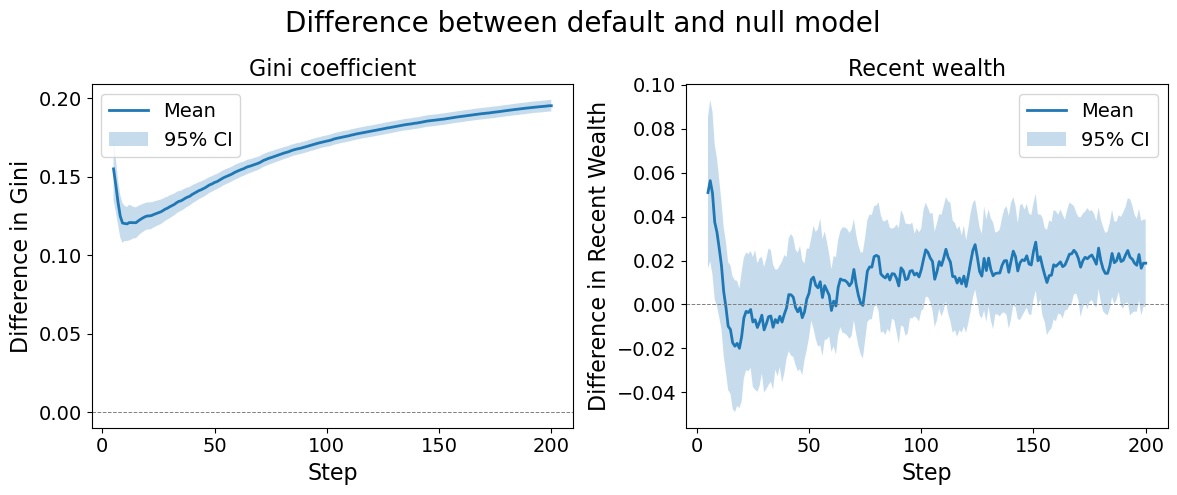

In [29]:
diff_df, _ = default_null(step_max=200, data_dir="Data/total_effect", outname="Figure/total_diff.png")

Default mean Gini: 0.2693 ± 0.0058
Null mean Gini: 0.2054 ± 0.0018
Difference: 0.0639
T-test: t = 10.451, p = 0.00000059


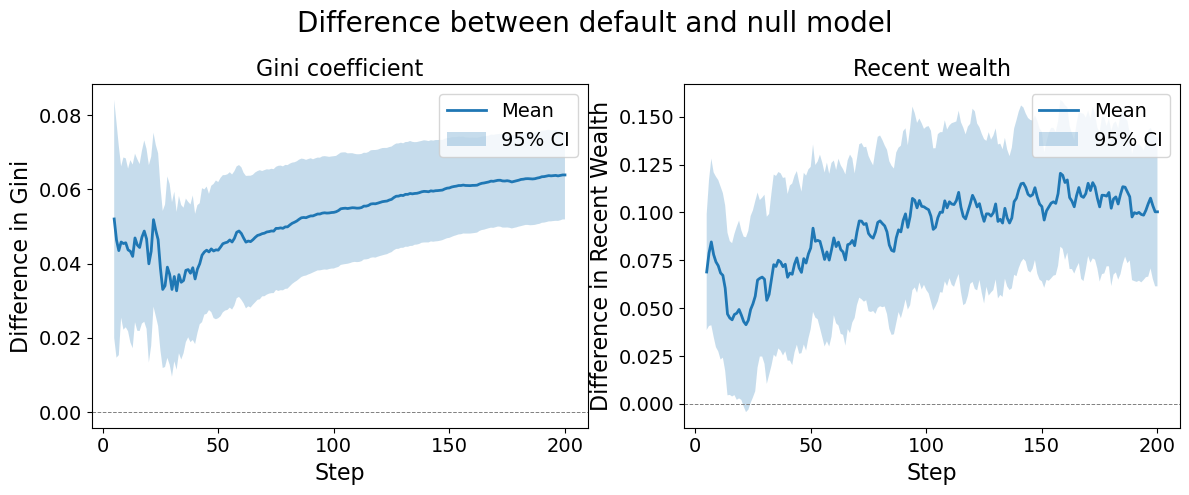

In [9]:
diff_df, _ = default_null(step_max=200, data_dir="Data/total_effect_norm", outname="Figure/total_diff_norm.png")
gini_stat_test("Data/total_effect_norm")

## Network influence: fix eta & lambda - null model

In [10]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    if x_sorted.sum() == 0:
        return 0
    return (np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted))


def load_runs(data_dir):
    file_pattern = os.path.join(data_dir, "agent_data_*.csv")
    all_files = glob.glob(file_pattern)

    runs = {
        "Null": [],
        "Doublefix": []
    }

    for fpath in all_files:
        filename = os.path.basename(fpath)
        if "null" in filename.lower():
            runs["Null"].append(pd.read_csv(fpath))
        else:
            runs["Doublefix"].append(pd.read_csv(fpath))
    return runs


def avg_metrics(df_list, col_rw="Recent Wealth"):
    frames = []
    for run_id, df in enumerate(df_list):
        steps, ginis, rws = [], [], []
        for step in df["Step"].unique():
            sub = df[df["Step"] == step]
            g = compute_gini(sub["Wealth"])
            rw = sub[col_rw].mean()
            steps.append(step); ginis.append(g); rws.append(rw)
        frames.append(pd.DataFrame({"Step": steps,
                                    "Gini": ginis,
                                    "RWealth": rws,
                                    "Run": run_id}))
    big = pd.concat(frames, ignore_index=True)
    agg = big.groupby("Step").agg({"Gini":  ["mean", "std", "count"],
                                   "RWealth":["mean", "std", "count"]})

    se = agg.xs("std",  level=1, axis=1) / np.sqrt(agg.xs("count", level=1, axis=1))
    mean = agg.xs("mean", level=1, axis=1)
    return mean, se


def base_doublefix(step_max=200, data_dir="Data/baseline_dix_eta_normalized", outname="eta_vs_baseline_diff.png"):
    runs = load_runs(data_dir)

    null_mean, null_se = avg_metrics(runs["Null"])
    base_mean, base_se = avg_metrics(runs["Doublefix"])

    steps = np.arange(step_max + 1)

    null_mean = null_mean.reindex(steps).ffill()
    base_mean = base_mean.reindex(steps).ffill()
    null_se = null_se.reindex(steps).ffill()
    base_se = base_se.reindex(steps).ffill()

    diff_mean = base_mean - null_mean
    diff_se = np.sqrt(null_se**2 + base_se**2)
    ci = 1.96 * diff_se

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    line1, = axes[0].plot(
        steps[5:], diff_mean["Gini"][5:], label="Mean", lw=2)
    fill1 = axes[0].fill_between(
        steps[5:],
        diff_mean["Gini"][5:] - ci["Gini"][5:],
        diff_mean["Gini"][5:] + ci["Gini"][5:],
        alpha=0.25, label="95% CI"
    )
    axes[0].set_title("Gini coefficient", fontsize=16)
    axes[0].set_ylabel("Difference in Gini", fontsize=16)
    axes[0].tick_params(axis='both', labelsize=14)

    line2, = axes[1].plot(
        steps[5:], diff_mean["RWealth"][5:], label="Mean", lw=2)
    fill2 = axes[1].fill_between(
        steps[5:],
        diff_mean["RWealth"][5:] - ci["RWealth"][5:],
        diff_mean["RWealth"][5:] + ci["RWealth"][5:],
        alpha=0.25, label="95% CI"
    )
    axes[1].set_title("Recent wealth", fontsize=16)
    axes[1].set_ylabel("Difference in Recent Wealth", fontsize=16)
    axes[1].tick_params(axis='both', labelsize=14)

    for ax in axes:
        ax.set_xlabel("Step", fontsize=16)
        ax.axhline(0, ls="--", c="grey", lw=0.7)

    fig.suptitle("Difference between doublefix and null model", fontsize=20, y=0.98)

    axes[0].legend(fontsize=14)
    axes[1].legend(fontsize=14)

    plt.tight_layout()
    plt.savefig(outname, dpi=150)

    return diff_mean, ci

In [16]:
def extract_final_ginis(df_list):
    ginis = []
    for df in df_list:
        last_step = df["Step"].max()
        g = compute_gini(df[df["Step"] == last_step]["Wealth"])
        ginis.append(g)
    return np.array(ginis)

def gini_stat_test(data_dir):
    runs = load_runs(data_dir)
    ginis_default = extract_final_ginis(runs["Baseline"])
    ginis_null = extract_final_ginis(runs["Null"])

    print(f"Default mean Gini: {ginis_default.mean():.4f} ± {ginis_default.std(ddof=1)/np.sqrt(len(ginis_default)):.4f}")
    print(f"Null mean Gini: {ginis_null.mean():.4f} ± {ginis_null.std(ddof=1)/np.sqrt(len(ginis_null)):.4f}")
    print(f"Difference: {ginis_default.mean() - ginis_null.mean():.4f}")

    t_stat, p_val = ttest_ind(ginis_default, ginis_null, equal_var=False)
    print(f"T-test: t = {t_stat:.3f}, p = {p_val:.8f}")

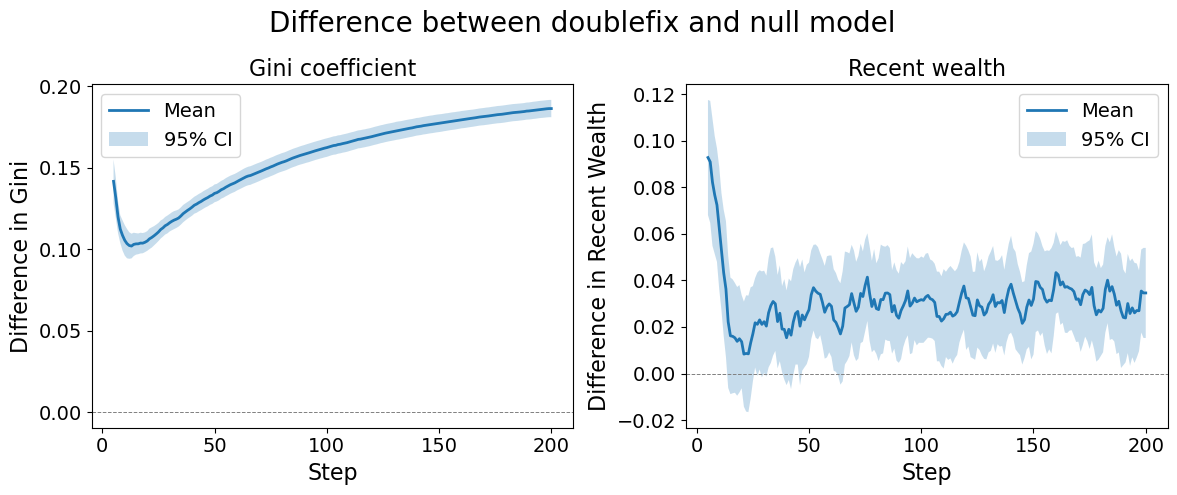

In [42]:
diff_df, _ = base_doublefix(step_max=200, data_dir="Data/doublefixed", outname="Figure/doublefixed.png")

KeyError: 'Baseline'

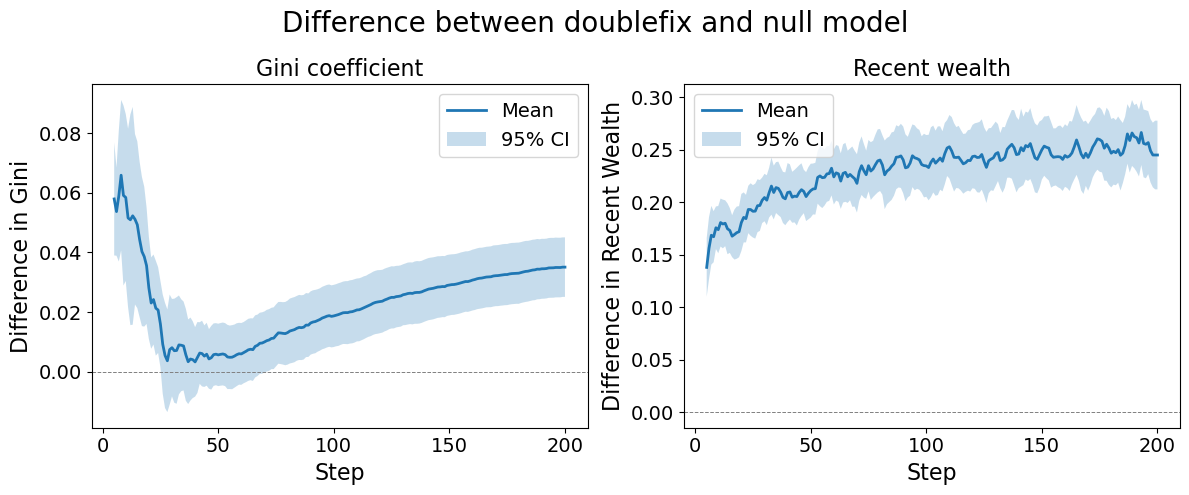

In [17]:
diff_df, _ = base_doublefix(step_max=200, data_dir="Data/doublefixed_norm", outname="Figure/doublefixed_norm.png")
gini_stat_test("Data/doublefixed_norm")

## Network convergence

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics

In [ ]:
def read_data(data_dir="Data/network_convergence"):
    file_pattern = os.path.join(data_dir, "model_data_*.csv")
    all_files = glob.glob(file_pattern)

    data_dict = {
        "HK": [],
        "WS": [],
        "ER": []
    }

    for fpath in all_files:
        filename = os.path.basename(fpath)

        if "HK" in filename:
            net_type = "HK"
        elif "WS" in filename:
            net_type = "WS"
        elif "ER" in filename:
            net_type = "ER"
        else:
            continue

        df = pd.read_csv(fpath)
        data_dict[net_type].append(df)

    return data_dict


def plot_network_convergence(data_dict, out_file="network_converge.png"):
    metrics_map = [
        ("M: Mean Degree",      "Average Degree"),
        ("M: Var of Degree",    "Degree Variance"),
        ("M: Avg Clustering",   "Clustering"),
        ("M: Avg Path Length",  "Average Path Length")
    ]

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8), sharex=True, sharey='row')

    for col_idx, net_key in enumerate(["HK", "WS", "ER"]):

        big_df = pd.concat(data_dict[net_key], ignore_index=True)
        unique_steps = sorted(big_df["Step"].unique())

        for row_idx, (col_name, display_name) in enumerate(metrics_map):
            ax = axes[row_idx, col_idx]

            mean_vals = []
            lower_vals = []
            upper_vals = []

            for step in unique_steps:
                sub_df = big_df[big_df["Step"] == step]

                vals = sub_df[col_name].dropna().tolist()

                m = statistics.mean(vals)
                stdev = statistics.pstdev(vals) if len(vals) > 1 else 0.0
                ci = 1.96 * stdev / (len(vals) ** 0.5) if len(vals) > 1 else 0.0
                mean_vals.append(m)
                lower_vals.append(m - ci)
                upper_vals.append(m + ci)

            ax.plot(unique_steps, mean_vals, label=display_name, lw=2)
            ax.fill_between(unique_steps, lower_vals, upper_vals, alpha=0.3)

            ax.axvline(x=20, color='red', linestyle='--', linewidth=1)
            ax.axvline(x=40, color='red', linestyle='--', linewidth=1)

            if row_idx == 0:
                ax.set_title(net_key, fontsize=12)
            if col_idx == 0:
                ax.set_ylabel(display_name, fontsize=12)
            if row_idx == 3:
                ax.set_xlabel("Step", fontsize=12)

    fig.suptitle("Network Convergence", fontsize=16)
    plt.tight_layout()
    plt.savefig(out_file, dpi=150)

In [ ]:
def compare_network_final_stage(
    data_dict,
    measures=[
        ("M: Var of Degree", "Var of Degree"),
        ("M: Avg Clustering", "Avg Clustering"),
        ("M: Avg Path Length", "Avg Path Length")
    ],
    final_n_steps=20
):
    rows = []
    for col_name, display_name in measures:
        means = {}
        stds = {}
        for net_type in ["ER", "HK", "WS"]:
            big_df = pd.concat(data_dict[net_type], ignore_index=True)
            big_df = big_df.sort_values(by="Step")
            last_steps = big_df["Step"].unique()[-final_n_steps:]
            sub_df = big_df[big_df["Step"].isin(last_steps)][col_name].dropna()
            mean_val = sub_df.mean()
            std_val = sub_df.std()
            means[net_type] = mean_val
            stds[net_type] = std_val

        net_means = [means[k] for k in ["ER", "HK", "WS"]]
        max_min_diff = np.nanmax(net_means) - np.nanmin(net_means)
        rel_diff = max_min_diff / np.nanmean(net_means) * 100

        row = {
            "Measure": display_name,
            "ER_mean": round(means["ER"], 3),
            "ER_std": round(stds["ER"], 3),
            "HK_mean": round(means["HK"], 3),
            "HK_std": round(stds["HK"], 3),
            "WS_mean": round(means["WS"], 3),
            "WS_std": round(stds["WS"], 3),
            "max-min_diff": round(max_min_diff, 4),
            "rel_diff(%)": "{:.2f}".format(rel_diff)
        }
        rows.append(row)

    results_df = pd.DataFrame(rows, columns=[
        "Measure", 
        "ER_mean", "ER_std", 
        "HK_mean", "HK_std", 
        "WS_mean", "WS_std", 
        "max-min_diff", "rel_diff(%)"
    ])
    return results_df


           Measure  ER_mean  ER_std  HK_mean  HK_std  WS_mean  WS_std  \
0    Var of Degree   32.739   2.326   28.638   2.662   32.652   2.130   
1   Avg Clustering    0.261   0.017    0.278   0.022    0.255   0.016   
2  Avg Path Length    6.536   0.636    6.783   0.815    6.399   0.622   

   max-min_diff rel_diff(%)  
0        4.1009       13.08  
1        0.0223        8.44  
2        0.3842        5.85  


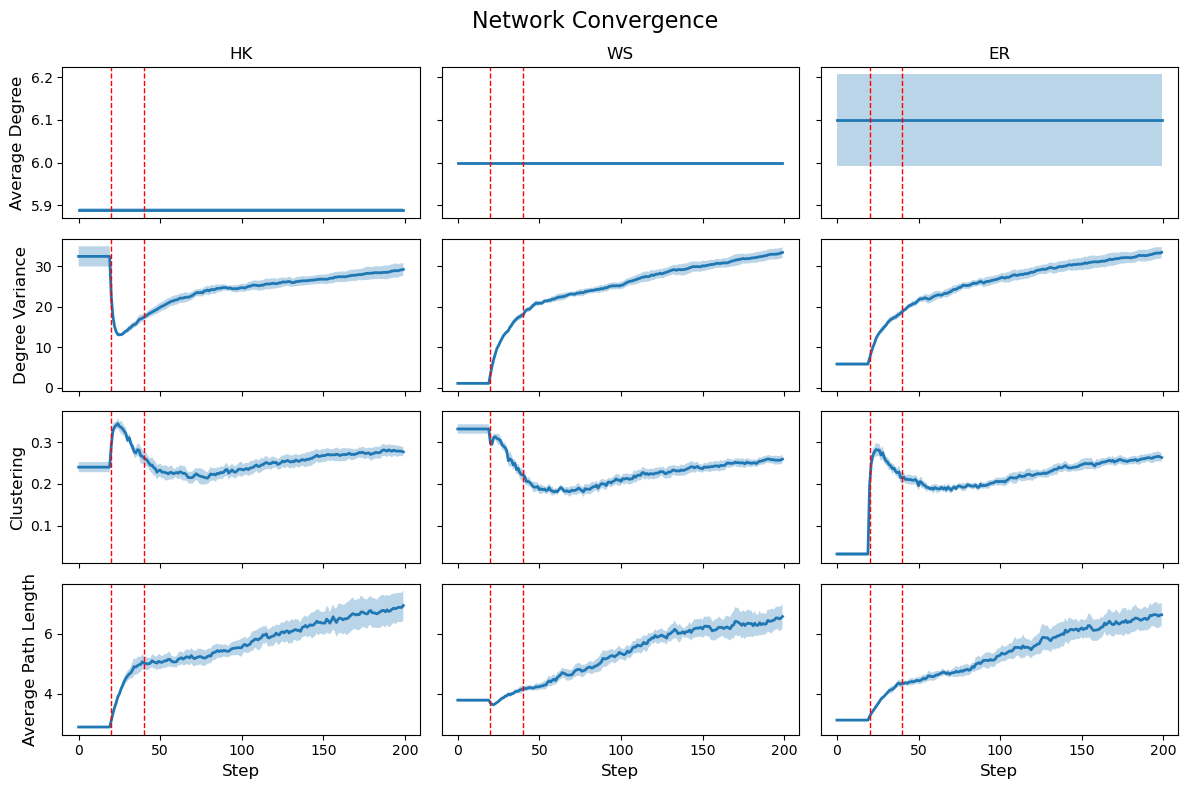

In [ ]:
data_dict = read_data("Data/network_convergence")
plot_network_convergence(data_dict, out_file="Figure/network_converge.png")

final_stage_df = compare_network_final_stage(data_dict, final_n_steps=20)
print(final_stage_df)

           Measure  ER_mean  ER_std  HK_mean  HK_std  WS_mean  WS_std  \
0    Var of Degree   26.341   2.345   23.691   2.176   22.192   2.579   
1   Avg Clustering    0.288   0.021    0.310   0.034    0.324   0.025   
2  Avg Path Length    7.504   0.765    7.870   1.148    8.364   0.581   

   max-min_diff rel_diff(%)  
0        4.1484       17.23  
1        0.0355       11.54  
2        0.8600       10.87  


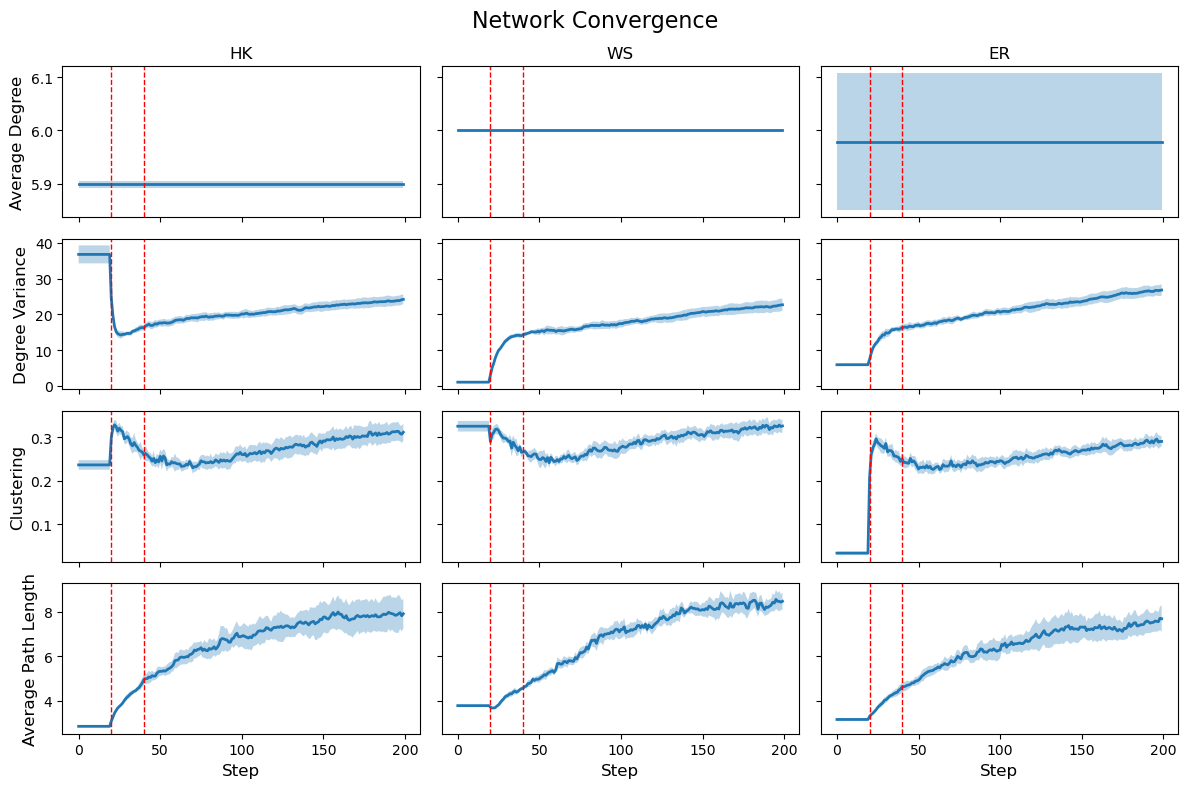

In [ ]:
data_dict = read_data("Data/network_convergence_norm")
plot_network_convergence(data_dict, out_file="Figure/network_converge_norm.png")

final_stage_df = compare_network_final_stage(data_dict, final_n_steps=20)
print(final_stage_df)

In [1]:
def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    if x_sorted.sum() == 0:
        return 0
    return (np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted))


def load_runs(data_dir):
    file_pattern = os.path.join(data_dir, "*.csv")
    all_files = glob.glob(file_pattern)

    runs = {
        "HK": [],
        "ER": []
    }

    for fpath in all_files:
        filename = os.path.basename(fpath)
        if "HK" in filename:
            runs["HK"].append(pd.read_csv(fpath))
        elif "ER" in filename:
            runs["ER"].append(pd.read_csv(fpath))
    return runs


def avg_metrics(df_list, col_rw="Recent Wealth"):
    frames = []
    for run_id, df in enumerate(df_list):
        steps, ginis, rws = [], [], []
        for step in df["Step"].unique():
            sub = df[df["Step"] == step]
            g = compute_gini(sub["Wealth"])
            rw = sub[col_rw].mean()
            steps.append(step); ginis.append(g); rws.append(rw)
        frames.append(pd.DataFrame({"Step": steps,
                                    "Gini": ginis,
                                    "RWealth": rws,
                                    "Run": run_id}))
    big = pd.concat(frames, ignore_index=True)
    agg = big.groupby("Step").agg({"Gini":  ["mean", "std", "count"],
                                   "RWealth":["mean", "std", "count"]})

    se = agg.xs("std",  level=1, axis=1) / np.sqrt(agg.xs("count", level=1, axis=1))
    mean = agg.xs("mean", level=1, axis=1)
    return mean, se


def hk_vs_er(step_max=200, data_dir="Data/gini_effect", outname="hk_er_diff.png"):
    runs = load_runs(data_dir)

    hk_mean, hk_se = avg_metrics(runs["HK"])
    er_mean, er_se = avg_metrics(runs["ER"])

    steps = np.arange(step_max + 1)

    hk_mean = hk_mean.reindex(steps).ffill()
    er_mean = er_mean.reindex(steps).ffill()
    hk_se = hk_se.reindex(steps).ffill()
    er_se = er_se.reindex(steps).ffill()

    diff_mean = hk_mean - er_mean
    diff_se = np.sqrt(hk_se**2 + er_se**2)
    ci = 1.96 * diff_se


    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    axes[0].plot(steps[5:], diff_mean["Gini"][5:], label="HK-ER")
    axes[0].fill_between(steps[5:],
                         diff_mean["Gini"][5:] - ci["Gini"][5:],
                         diff_mean["Gini"][5:] + ci["Gini"][5:],
                         alpha=0.25)
    axes[0].set_title("Gini coefficient", fontsize=16)
    axes[0].set_ylabel("Difference in Gini", fontsize=14)

    axes[1].plot(steps[5:], diff_mean["RWealth"][5:], label="HK-ER")
    axes[1].fill_between(steps[5:],
                         diff_mean["RWealth"][5:] - ci["RWealth"][5:],
                         diff_mean["RWealth"][5:] + ci["RWealth"][5:],
                         alpha=0.25)
    axes[1].set_title("Recent Wealth", fontsize=16)
    axes[1].set_ylabel("Difference in Recent Wealth", fontsize=14)

    for ax in axes:
        ax.set_xlabel("Step", fontsize=14)
        ax.axhline(0, ls="--", c="grey", lw=0.8)

    plt.suptitle("Difference between HK and ER", fontsize=18)
    plt.tight_layout()
    plt.legend()
    plt.savefig(outname, dpi=150)

    return diff_mean, ci

(          Gini   RWealth
 Step                    
 0     0.030622  0.003033
 1     0.021321 -0.013490
 2     0.025343 -0.009683
 3     0.023762 -0.006505
 4     0.032173 -0.002875
 ...        ...       ...
 196  -0.006774 -0.005069
 197  -0.006792 -0.001902
 198  -0.006788 -0.000996
 199  -0.006755  0.000401
 200  -0.006755  0.000401
 
 [201 rows x 2 columns],
           Gini   RWealth
 Step                    
 0     0.030877  0.015618
 1     0.029111  0.022801
 2     0.023938  0.028665
 3     0.024120  0.029066
 4     0.032221  0.031244
 ...        ...       ...
 196   0.011555  0.050105
 197   0.011559  0.050487
 198   0.011531  0.049192
 199   0.011521  0.049312
 200   0.011521  0.049312
 
 [201 rows x 2 columns])

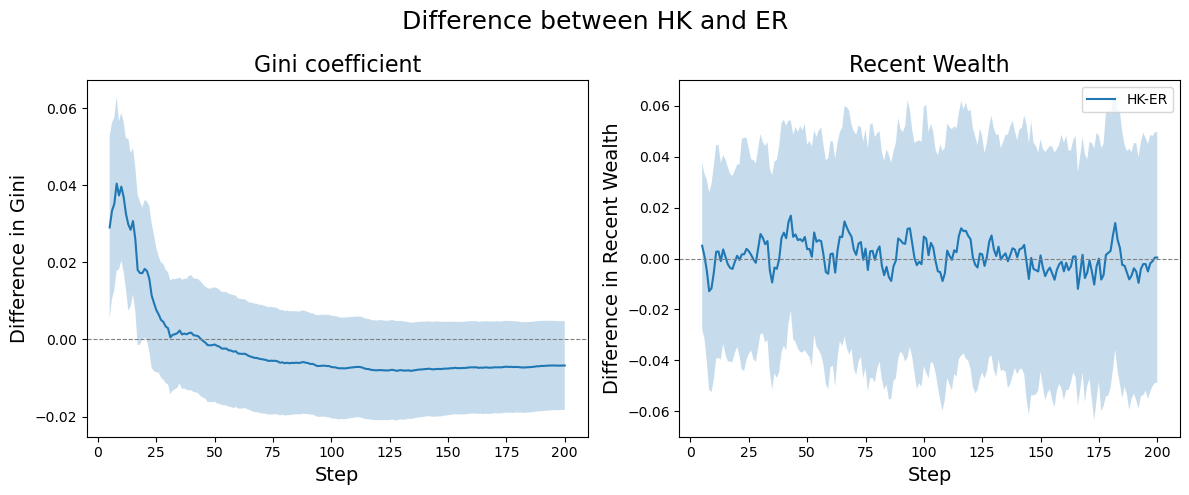

In [4]:
hk_vs_er(data_dir="Data/hk_er", outname="Figure/hk_vs_er.png")

## rewiring p

In [ ]:
import re
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

In [ ]:
def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    idx = np.arange(1, n + 1)
    s = x_sorted.sum()
    return 0 if s == 0 else (np.sum((2 * idx - n - 1) * x_sorted) / (n * s))


def load_rewire_runs(data_dir="Data/rewiring"):
    pattern = re.compile(r"agent_data_rewire_([\d.]+)_")
    runs = {}
    for f in glob.glob(os.path.join(data_dir, "agent_data_rewire_*.csv")):
        m = pattern.search(os.path.basename(f))
        p = float(m.group(1))
        runs.setdefault(p, []).append(pd.read_csv(f))
    return runs


def gini_series(df, wealth_col="Wealth"):
    out = (df.groupby("Step")[wealth_col]
             .apply(compute_gini)
             .rename("gini"))
    return out

def recent_wealth_series(df, col="Recent Wealth"):
    out = (df.groupby("Step")[col].mean().rename("recent_wealth"))
    return out

def plot_rewiring(step_max=200, data_dir="Data/rewiring",probs=(0.25, 0.5, 0.75, 1), outname="rewiring.png"):
    runs = load_rewire_runs(data_dir)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    ax = axes[0]
    for p in sorted(probs):
        gs = [gini_series(df) for df in runs[p]]
        steps = np.arange(step_max + 1)
        mat = np.vstack([s.reindex(steps).interpolate().values for s in gs])
        mean = mat.mean(axis=0)
        if mat.shape[0] > 1:
            std = mat.std(axis=0, ddof=1)
            ci = 1.96 * std / np.sqrt(mat.shape[0])
        else:
            ci = np.zeros_like(mean)
        ax.plot(steps[5:], mean[5:], lw=2, label=f"p={p}")
        ax.fill_between(steps[5:], mean[5:] - ci[5:], mean[5:] + ci[5:], alpha=0.25)
    ax.set_xlabel("Step", fontsize=14)
    ax.set_ylabel("Average Gini", fontsize=14)
    ax.legend()

    ax = axes[1]
    for p in sorted(probs):
        series_list = [recent_wealth_series(df) for df in runs[p]]
        steps = np.arange(step_max + 1)
        mat = np.vstack([s.reindex(steps).interpolate().values for s in series_list])
        mean = mat.mean(axis=0)
        if mat.shape[0] > 1:
            std = mat.std(axis=0, ddof=1)
            ci = 1.96 * std / np.sqrt(mat.shape[0])
        else:
            ci = np.zeros_like(mean)
        ax.plot(steps[5:], mean[5:], lw=2, label=f"p={p}")
        ax.fill_between(steps[5:], mean[5:] - ci[5:], mean[5:] + ci[5:], alpha=0.25)
    ax.set_xlabel("Step", fontsize=14)
    ax.set_ylabel("Average Recent Wealth", fontsize=14)
    ax.legend()
    plt.suptitle("Effect of rewiring probability", fontsize=18)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)


def stats_test(runs,value_func,step_max=200,final_n_steps=20):
    group_values = {}
    for p in sorted(runs.keys()):
        group = []
        for df in runs[p]:
            series = value_func(df)
            steps = np.arange(step_max+1)
            s = series.reindex(steps).interpolate()
            final_mean = s.values[-final_n_steps:].mean()
            group.append(final_mean)
        group_values[p] = group

    samples = [group_values[p] for p in sorted(group_values.keys())]
    fval, pval = f_oneway(*samples)

    res = {
        "rew_p": list(sorted(group_values.keys())),
        "means": [np.mean(group_values[p]) for p in sorted(group_values.keys())],
        "stds": [np.std(group_values[p]) for p in sorted(group_values.keys())],
        "F": fval,
        "p-value": pval
    }
    return res

Gini Final ANOVA: {'p_values': [0.25, 0.5, 0.75, 1.0], 'means': [0.23942643001720193, 0.25939109761136353, 0.2735110676113351, 0.26515489953051946], 'stds': [0.007797356803642873, 0.015045926532079031, 0.020384277245451162, 0.018909002463537168], 'F': 3.1750126073983247, 'p-value': 0.05283129498793647}
Recent Wealth Final ANOVA: {'p_values': [0.25, 0.5, 0.75, 1.0], 'means': [0.48482412499999994, 0.45486000000000004, 0.468469875, 0.46456], 'stds': [0.045838269141692665, 0.013072779382413281, 0.03049062527903048, 0.030729890314643165], 'F': 0.6015529232689754, 'p-value': 0.6233365581781237}


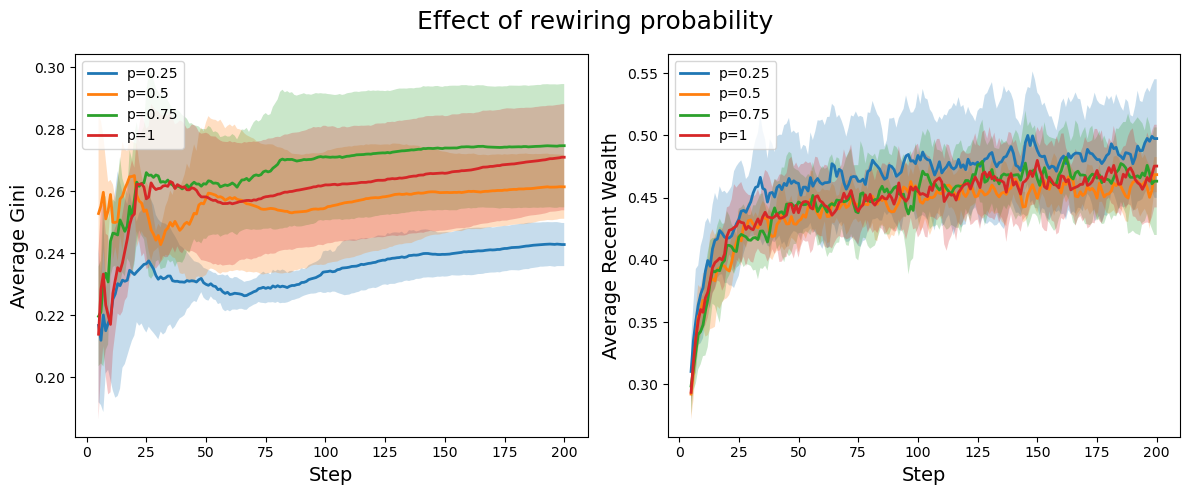

In [37]:
plot_rewiring(step_max=200, data_dir="Data/rewiring_norm",probs=(0.25, 0.5, 0.75, 1),outname="Figure/rewiring_norm.png")


runs = load_rewire_runs(data_dir="Data/rewiring_norm")
gini_stats = stats_test(runs, gini_series, step_max=150, final_n_steps=20)
rw_stats = stats_test(runs, recent_wealth_series, step_max=150, final_n_steps=20)
print("Gini Final ANOVA:", gini_stats)
print("Recent Wealth Final ANOVA:", rw_stats)

Gini Final ANOVA: {'p_values': [0.25, 0.5, 0.75, 1.0], 'means': [0.17627873494410523, 0.20750727600215785, 0.2084048671999384, 0.21952755209939126], 'stds': [0.004024814522939141, 0.006892334560674361, 0.00706418117179235, 0.0023748596196449907], 'F': 69.54994574978893, 'p-value': 5.566993316088815e-12}
Recent Wealth Final ANOVA: {'p_values': [0.25, 0.5, 0.75, 1.0], 'means': [0.8800200000000001, 0.9074403571428572, 0.9123560714285713, 0.9008267857142858], 'stds': [0.023974262836872144, 0.01374160044929864, 0.01684287565884111, 0.013880811891799034], 'F': 3.9215058032714794, 'p-value': 0.020690940980220163}


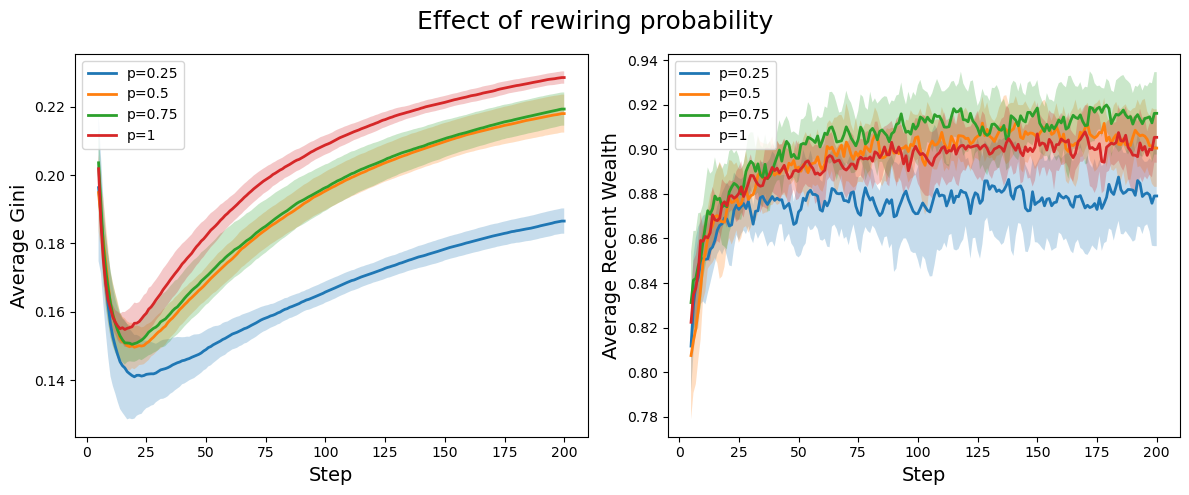

In [38]:
plot_rewiring(step_max=200, data_dir="Data/rewiring",probs=(0.25, 0.5, 0.75, 1),outname="Figure/rewiring.png")


runs = load_rewire_runs(data_dir="Data/rewiring")
gini_stats = stats_test(runs, gini_series, step_max=150, final_n_steps=20)
rw_stats = stats_test(runs, recent_wealth_series, step_max=150, final_n_steps=20)
print("Gini Final ANOVA:", gini_stats)
print("Recent Wealth Final ANOVA:", rw_stats)

## Homophily

In [39]:
import glob
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    if x_sorted.sum() == 0:
        return 0
    return (np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted))

def load_alpha_runs(data_dir):
    file_pattern = os.path.join(data_dir, "agent_data_*.csv")
    all_files = glob.glob(file_pattern)
    pat = re.compile(r"agent_data_([0-9.]+)_")
    runs = {}
    for fpath in all_files:
        filename = os.path.basename(fpath)
        m = pat.match(filename)
        alpha = float(m.group(1))
        runs.setdefault(alpha, []).append(pd.read_csv(fpath))
    return runs

def collect_alpha(runs, step=None, col_rw="Recent Wealth"):

    alpha_list, gini_mean, gini_se, rw_mean, rw_se = [], [], [], [], []
    for alpha in sorted(runs.keys()):
        df_list = runs[alpha]
        gini_vals, rw_vals = [], []
        for df in df_list:
            if step is None:
                s = df["Step"].max()
            else:
                s = step
            sub = df[df["Step"] == s]
            g = compute_gini(sub["Wealth"])
            rw = sub[col_rw].mean()
            gini_vals.append(g)
            rw_vals.append(rw)
        alpha_list.append(alpha)
        gini_mean.append(np.mean(gini_vals))
        gini_se.append(np.std(gini_vals, ddof=1)/np.sqrt(len(gini_vals)))
        rw_mean.append(np.mean(rw_vals))
        rw_se.append(np.std(rw_vals, ddof=1)/np.sqrt(len(rw_vals)))
    return np.array(alpha_list), np.array(gini_mean), np.array(gini_se), np.array(rw_mean), np.array(rw_se)

def plot_homophily(data_dir, step=None, outname="homophily.png",):
    runs = load_alpha_runs(data_dir)
    alphas, gini_mean, gini_se, rw_mean, rw_se = collect_alpha(runs, step=step)
    sort_idx = np.argsort(alphas)
    alphas = alphas[sort_idx]
    gini_mean = gini_mean[sort_idx]
    gini_se = gini_se[sort_idx]
    rw_mean = rw_mean[sort_idx]
    rw_se = rw_se[sort_idx]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    ax = axes[0]
    ax.plot(alphas, gini_mean, label="Gini")
    ax.fill_between(alphas, gini_mean - 1.96 * gini_se, gini_mean + 1.96 * gini_se, alpha=0.2, label="95% CI")
    ax.set_xlabel(r"$\alpha$", fontsize=14)
    ax.set_ylabel("Gini", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=12)

    ax = axes[1]
    ax.plot(alphas, rw_mean, label="Recent Wealth")
    ax.fill_between(alphas, rw_mean - 1.96 * rw_se, rw_mean + 1.96 * rw_se, alpha=0.2, label="95% CI")
    ax.set_xlabel(r"$\alpha$", fontsize=14)
    ax.set_ylabel("Recent Wealth", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend(fontsize=12)
    plt.suptitle(r"Effect of homophily parameter $\alpha$", fontsize=18)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)

In [52]:
def load_alpha_model_data(data_dir):
    file_pattern = os.path.join(data_dir, "model_data_*.csv")
    all_files = glob.glob(file_pattern)
    pat = re.compile(r"model_data_([0-9.]+)_")
    runs = {}
    for fpath in all_files:
        filename = os.path.basename(fpath)
        m = pat.match(filename)
        if m is not None:
            alpha = float(m.group(1))
            runs.setdefault(alpha, []).append(pd.read_csv(fpath))
    return runs

def collect_model_metric_by_alpha(runs, step=None):
    alpha_list, clust_mean, clust_se, path_mean, path_se, var_mean, var_se = [], [], [], [], [], [], []
    for alpha in sorted(runs.keys()):
        df_list = runs[alpha]
        clustering_vals, pathlen_vals, vardeg_vals = [], [], []
        for df in df_list:
            if step is None:
                s = df["Step"].max()
            else:
                s = step
            sub = df[df["Step"] == s]
            clustering_vals.append(sub["M: Avg Clustering"].mean())
            pathlen_vals.append(sub["M: Avg Path Length"].mean())
            vardeg_vals.append(sub["M: Var of Degree"].mean())
        alpha_list.append(alpha)
        clust_mean.append(np.mean(clustering_vals))
        clust_se.append(np.std(clustering_vals, ddof=1) / np.sqrt(len(clustering_vals)))
        path_mean.append(np.mean(pathlen_vals))
        path_se.append(np.std(pathlen_vals, ddof=1) / np.sqrt(len(pathlen_vals)))
        var_mean.append(np.mean(vardeg_vals))
        var_se.append(np.std(vardeg_vals, ddof=1) / np.sqrt(len(vardeg_vals)))
    return (
        np.array(alpha_list), 
        np.array(clust_mean), np.array(clust_se), 
        np.array(path_mean), np.array(path_se), 
        np.array(var_mean), np.array(var_se)
    )

def plot_alpha_network(data_dir, step=None, outname="alpha_vs_network.png"):
    runs = load_alpha_model_data(data_dir)
    (alphas, 
     clust_mean, clust_se, 
     path_mean, path_se, 
     var_mean, var_se) = collect_model_metric_by_alpha(runs, step=step)
    sort_idx = np.argsort(alphas)
    alphas = alphas[sort_idx]
    clust_mean = clust_mean[sort_idx]
    clust_se = clust_se[sort_idx]
    path_mean = path_mean[sort_idx]
    path_se = path_se[sort_idx]
    var_mean = var_mean[sort_idx]
    var_se = var_se[sort_idx]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    ax = axes[0]
    ax.plot(alphas, clust_mean, label="Clustering")
    ax.fill_between(alphas, clust_mean - 1.96 * clust_se, clust_mean + 1.96 * clust_se, alpha=0.2)
    ax.set_xlabel(r"$\alpha$", fontsize=14)
    ax.set_ylabel("Avg Clustering", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title("Clustering", fontsize=12)

    ax = axes[1]
    ax.plot(alphas, path_mean, label="Path Length")
    ax.fill_between(alphas, path_mean - 1.96 * path_se, path_mean + 1.96 * path_se, alpha=0.2)
    ax.set_xlabel(r"$\alpha$", fontsize=14)
    ax.set_ylabel("Avg Path Length", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title("Path Length", fontsize=12)

    ax = axes[2]
    ax.plot(alphas, var_mean, label="Var of Degree")
    ax.fill_between(alphas, var_mean - 1.96 * var_se, var_mean + 1.96 * var_se, alpha=0.2)
    ax.set_xlabel(r"$\alpha$", fontsize=14)
    ax.set_ylabel("Var of Degree", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title("Var of Degree", fontsize=12)

    plt.suptitle(r"Effect of homophily parameter $\alpha$", fontsize=18)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)

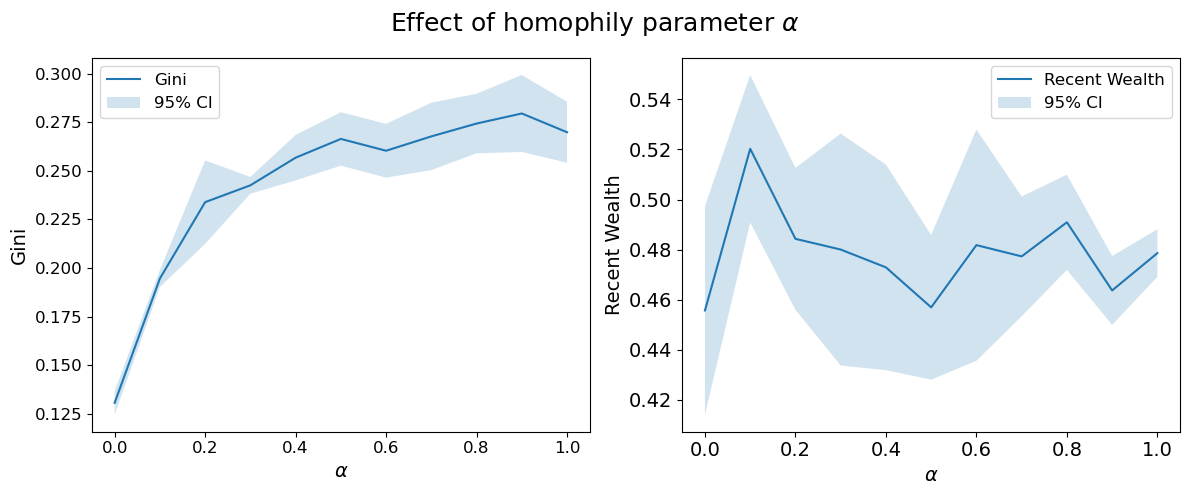

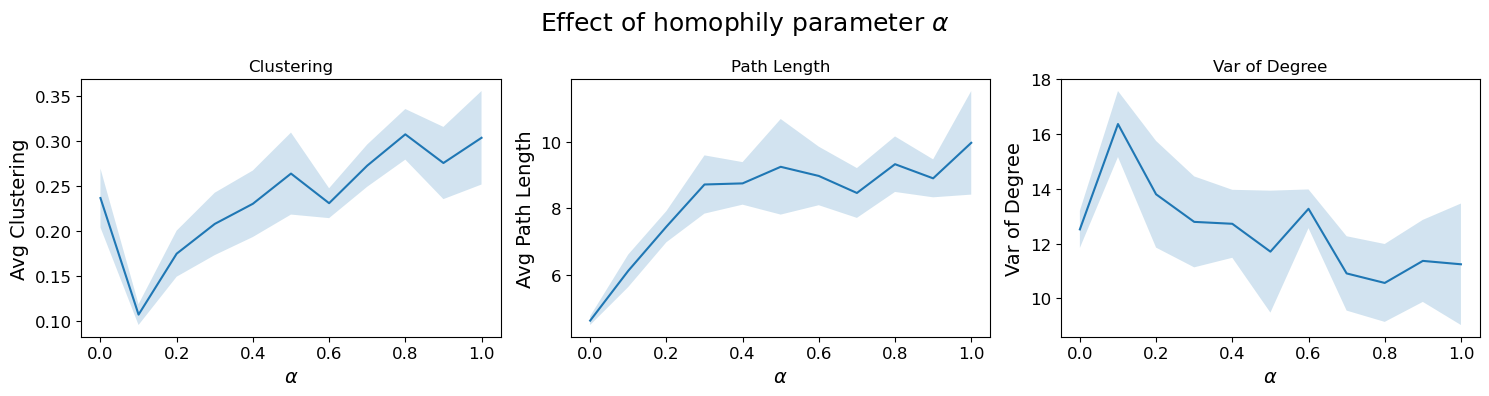

In [53]:
plot_homophily("Data/homophily_norm", outname="Figure/homophily_norm.png")
plot_alpha_network("Data/homophily_norm", outname="Figure/alpha_vs_network_norm.png")

In [ ]:
# plot_homophily("Data/homophily", outname="Figure/homophily.png")
# plot_alpha_network("Data/homophily", outname="Figure/alpha_vs_network.png")

## Assortativity

In [56]:
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [58]:
def read_data(data_dir="Data/assortativity"):
    pattern = re.compile(r"model_data_.*\.csv")
    files = [f for f in glob.glob(os.path.join(data_dir, "*.csv")) if pattern.search(os.path.basename(f))]
    return [pd.read_csv(f) for f in files]

def load_agent_runs(data_dir="Data/assortativity"):
    pat = re.compile(r"agent_data_.*\.csv")
    return [pd.read_csv(f) for f in glob.glob(os.path.join(data_dir, "*.csv")) if pat.search(os.path.basename(f))]

def corr_series(df, col_x="Rationality", col_y="Wealth", steps=None):
    if steps is None: steps = df["Step"].unique()
    vals = []
    for s in steps:
        sub = df[df["Step"] == s]
        if len(sub) > 1:
            r, _ = pearsonr(sub[col_x], sub[col_y])
        else:
            r = np.nan
        vals.append(r)
    return pd.Series(vals, index=steps)

def plot_assortativity(data_dir="Data/assortativity",step_start=5,outname="assortativity.png"):

    dfs = read_data(data_dir)
    steps = dfs[0]["Step"].unique()
    steps = steps[steps >= step_start]
    risk_mtx, rat_mtx = [], []
    for df in dfs:
        df = df[df["Step"] >= step_start]
        risk = df.set_index("Step")["Risk Assortativity"].reindex(steps).interpolate().values
        rat = df.set_index("Step")["Rationality Assortativity"].reindex(steps).interpolate().values
        risk_mtx.append(risk)
        rat_mtx.append(rat)
    risk_mtx = np.vstack(risk_mtx)
    rat_mtx = np.vstack(rat_mtx)
    risk_mean = risk_mtx.mean(axis=0)
    rat_mean = rat_mtx.mean(axis=0)
    risk_ci = 1.96 * risk_mtx.std(axis=0, ddof=1) / np.sqrt(len(dfs))
    rat_ci = 1.96 * rat_mtx.std(axis=0, ddof=1) / np.sqrt(len(dfs))

    dfs_agents = load_agent_runs(data_dir)
    corr_specs = [
        ("Rationality", "Wealth", "corr(Rationality, Wealth)"),
        ("Player Risk Aversion", "Wealth", "corr(Risk Aversion, Wealth)"),
        ("Rationality", "Recent Wealth", "corr(Rationality, Recent Wealth)"),
        ("Player Risk Aversion", "Recent Wealth", "corr(Risk Aversion, Recent Wealth)")
    ]
    corr_steps = np.arange(step_start, dfs_agents[0]["Step"].max() + 1)

    fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=False)

    ax = axes[0]
    ax.plot(steps, risk_mean, lw=2, label="Risk Assortativity")
    ax.fill_between(steps, risk_mean - risk_ci, risk_mean + risk_ci, alpha=0.25)
    ax.plot(steps, rat_mean, lw=2, label="Rationality Assortativity")
    ax.fill_between(steps, rat_mean - rat_ci, rat_mean + rat_ci, alpha=0.25)
    ax.set_xlabel("Step", fontsize=14)
    ax.set_ylabel("Assortativity", fontsize=14)
    ax.set_title("Assortativity over time", fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=12)

    ax = axes[1]
    for col_x, col_y, label in corr_specs:
        mat = []
        for df in dfs_agents:
            s = corr_series(df, col_x=col_x, col_y=col_y, steps=corr_steps)
            mat.append(s.values)
        mat = np.vstack(mat)
        mean = np.nanmean(mat, axis=0)
        se = np.nanstd(mat, ddof=1, axis=0) / np.sqrt(mat.shape[0])
        ci = 1.96 * se
        ax.plot(corr_steps, mean, lw=2, label=label)
        ax.fill_between(corr_steps, mean - ci, mean + ci, alpha=0.2)
    ax.set_xlabel("Step", fontsize=14)
    ax.set_ylabel("Pearson r", fontsize=14)
    ax.set_title("Correlation over time", fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(outname, dpi=150)

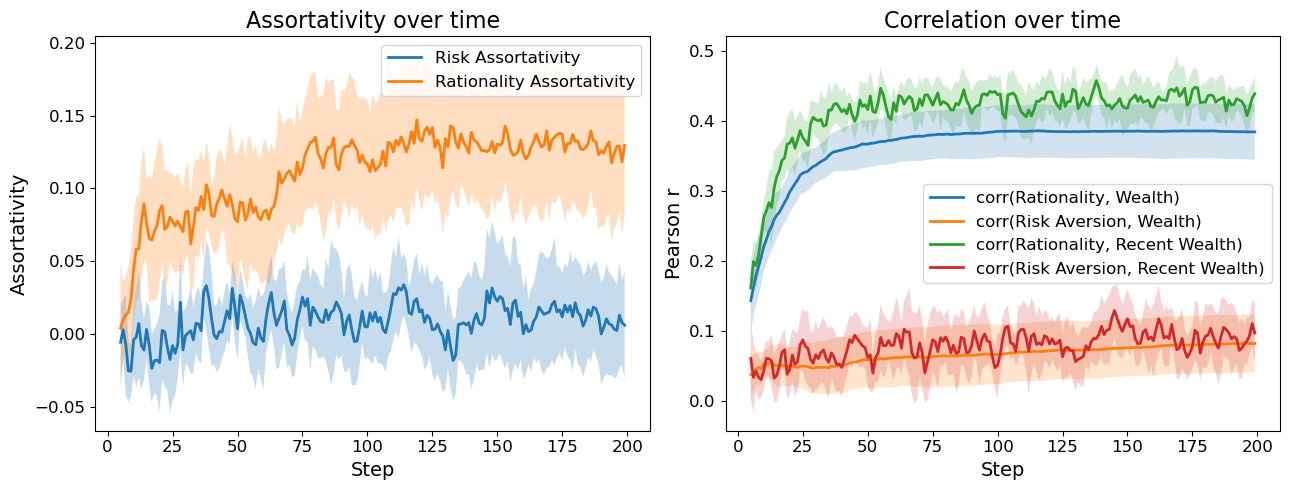

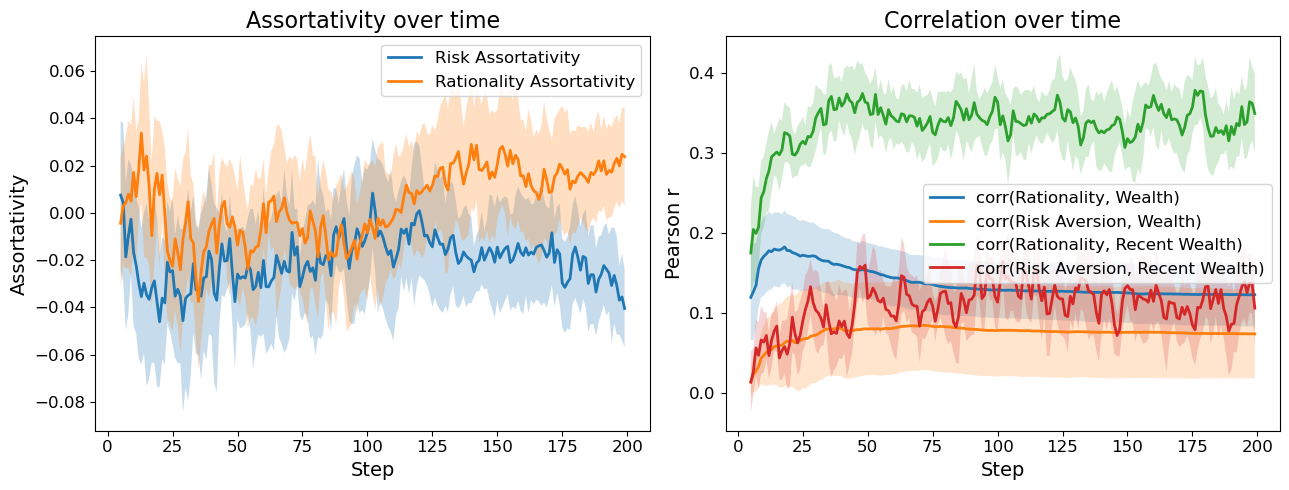

In [59]:
plot_assortativity(data_dir="Data/assortativity_norm",outname="Figure/assortativity_norm.png")
plot_assortativity(data_dir="Data/assortativity",outname="Figure/assortativity.png")

## eta & lambda

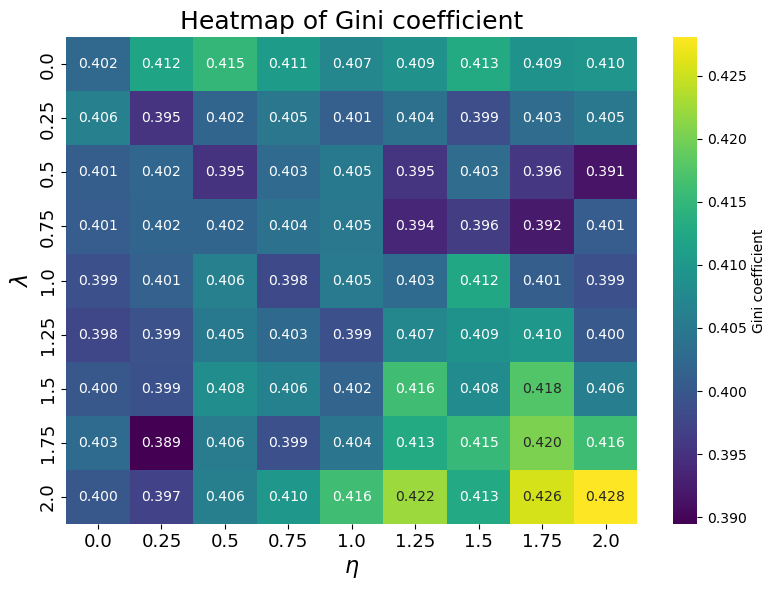

In [7]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    if x_sorted.sum() == 0:
        return 0
    return (np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted))

def extract_eta_lambda(filename):
    pat = re.compile(r"agent_data_([-\d\.]+)_([-\d\.]+)_")
    m = pat.search(os.path.basename(filename))
    if not m:
        raise ValueError(f"Filename does not match pattern: {filename}")
    eta = float(m.group(1))
    lambd = float(m.group(2))
    return eta, lambd

def mean_gini_table_eta_lambda(data_dir="Data/gini_heatmap"):
    bag = {}
    for f in glob.glob(os.path.join(data_dir, "agent_data_*.csv")):
        eta, lambd = extract_eta_lambda(f)
        df = pd.read_csv(f)
        gini = compute_gini(df["Wealth"])
        bag.setdefault((eta, lambd), []).append(gini)
    rows = [
        {"eta": k[0], "lambda": k[1], "gini": np.mean(v)}
        for k, v in bag.items()
    ]
    df = pd.DataFrame(rows)
    return df.pivot(index="lambda", columns="eta", values="gini").sort_index().sort_index(axis=1)

def plot_gini_heatmap_eta_lambda(data_dir="Data/gini_heatmap", outname="gini_eta_lambda_heatmap.png"):
    table = mean_gini_table_eta_lambda(data_dir)
    plt.figure(figsize=(8,6))
    sns.heatmap(table, cmap="viridis", annot=True, fmt=".3f",
                cbar_kws={'label': 'Gini coefficient'})
    plt.title("Heatmap of Gini coefficient", fontsize=18)
    plt.xlabel(r"$\eta$", fontsize=16)
    plt.ylabel(r"$\lambda$", fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)

plot_gini_heatmap_eta_lambda(data_dir="Data/property_norm", outname="Figure/property_norm.png")

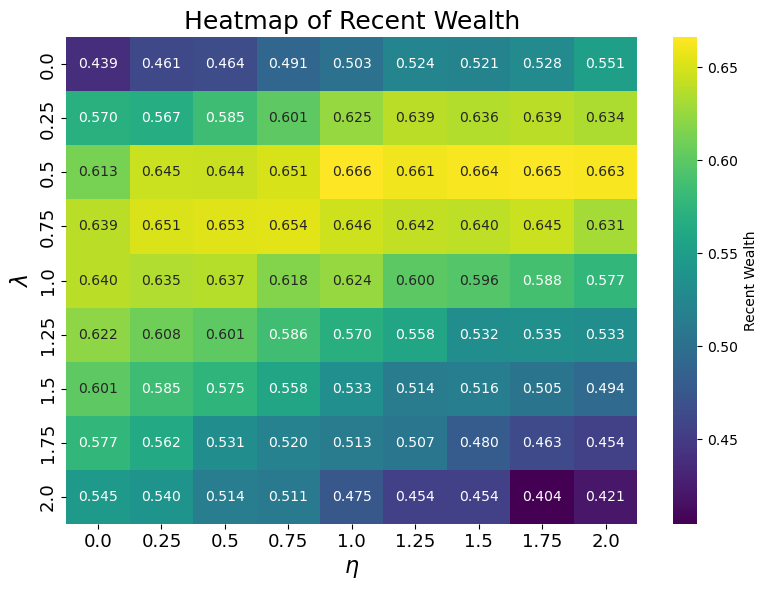

In [8]:
def mean_recentwealth_table_eta_lambda(data_dir="Data/gini_heatmap"):
    bag = {}
    for f in glob.glob(os.path.join(data_dir, "agent_data_*.csv")):
        eta, lambd = extract_eta_lambda(f)
        df = pd.read_csv(f)
        value = df["Recent Wealth"].mean()
        bag.setdefault((eta, lambd), []).append(value)
    rows = [
        {"eta": k[0], "lambda": k[1], "recent_wealth": np.mean(v)}
        for k, v in bag.items()
    ]
    df = pd.DataFrame(rows)
    return df.pivot(index="lambda", columns="eta", values="recent_wealth").sort_index().sort_index(axis=1)

def plot_recentwealth_heatmap_eta_lambda(data_dir="Data/gini_heatmap", outname="recentwealth_eta_lambda_heatmap.png"):
    table = mean_recentwealth_table_eta_lambda(data_dir)
    plt.figure(figsize=(8,6))
    sns.heatmap(table, cmap="viridis", annot=True, fmt=".3f",
                cbar_kws={'label': 'Recent Wealth'})
    plt.title("Heatmap of Recent Wealth", fontsize=18)
    plt.xlabel(r"$\eta$", fontsize=16)
    plt.ylabel(r"$\lambda$", fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)


plot_recentwealth_heatmap_eta_lambda(data_dir="Data/property_norm", outname="Figure/property_rw_norm.png")

## mutation

In [9]:
import os
import re
import ast
import glob
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.ndimage import maximum_filter
from pathlib import Path

In [13]:
def parse_ug(s):
    if isinstance(s, str):
        return len(ast.literal_eval(s))
    elif isinstance(s, list):
        return len(s)
    else:
        return 0

def ug_series(df):
    df = df.copy()
    df["UG_left"] = df["Unique Games"].apply(parse_ug)
    return df.set_index("Step")["UG_left"]

def load_mutation_runs(data_dir="Data/mutation"):
    pat = re.compile(r"agent_data_([0-9.]+)_")
    runs = {}
    for f in glob.glob(os.path.join(data_dir, "agent_data_*.csv")):
        m = pat.search(os.path.basename(f))
        rate = float(m.group(1))
        runs.setdefault(rate, []).append(pd.read_csv(f))
    return runs

def lastN_mean_se(df_list, last_n=10):
    vals = [
        ug_series(df).iloc[-last_n:].mean()
        for df in df_list
    ]
    mean = np.mean(vals)
    se = np.std(vals, ddof=1) / np.sqrt(len(vals))
    return mean, se, len(vals)


def count_local_maxima(u_vals, v_vals, gridsize=40, thr_ratio=0.05):
    pts = np.vstack([u_vals, v_vals])
    kde = gaussian_kde(pts)
    u_lin = np.linspace(min(u_vals), max(u_vals), gridsize)
    v_lin = np.linspace(min(v_vals), max(v_vals), gridsize)
    uu, vv = np.meshgrid(u_lin, v_lin)
    dens = kde(np.vstack([uu.ravel(), vv.ravel()])).reshape(gridsize, gridsize)
    peak_mask = (dens == maximum_filter(dens, size=3, mode='constant'))
    peak_mask &= dens > dens.max() * thr_ratio
    return int(peak_mask.sum())


def local_maxima_mean_se(df_list):
    vals = [
    count_local_maxima(*extract_uv(df["UV"]))
    for df in df_list]
    mean = np.mean(vals)
    se = np.std(vals, ddof=1) / np.sqrt(len(vals))
    return mean, se, len(vals)


def compute_entropy(u_vals, v_vals, gridsize=40):
    pts = np.vstack([u_vals, v_vals])
    kde = gaussian_kde(pts)
    u_lin = np.linspace(min(u_vals), max(u_vals), gridsize)
    v_lin = np.linspace(min(v_vals), max(v_vals), gridsize)
    uu, vv = np.meshgrid(u_lin, v_lin)
    dens = kde(np.vstack([uu.ravel(), vv.ravel()]))
    dens = dens / dens.sum()
    H = -np.sum(dens * np.log(dens + 1e-12))
    H_max = np.log(dens.size)
    return H / H_max   


def compute_entropy_mean_se(df_list):
    vals = [
    compute_entropy(*extract_uv(df["UV"]))
    for df in df_list]
    mean = np.mean(vals)
    se = np.std(vals, ddof=1) / np.sqrt(len(vals))
    return mean, se, len(vals)


def extract_uv(series):
    u_vals, v_vals = [], []
    for item in series:
        u, v = np.nan, np.nan
        if isinstance(item, (tuple, list)):
            u, v = item
        elif isinstance(item, str):
            u, v = ast.literal_eval(item)
        if not (math.isnan(u) or math.isnan(v)):
            u_vals.append(float(u))
            v_vals.append(float(v))
    return u_vals, v_vals


def last_mean_se_rw(df_list, last_n=10, col="Recent Wealth"):
    vals = [
        df.groupby("Step")[col].mean().iloc[-1]
        for df in df_list
    ]
    mean = np.mean(vals)
    se   = np.std(vals, ddof=1) / np.sqrt(len(vals))
    return mean, se, len(vals)


def mutation_rw_plot(data_dir="Data/mutation",outname="mutation.png",last_n=10):
    pat = re.compile(r"_(\d+(?:\.\d+)?)_")
    models, agents = {}, {}

    for fp in glob.glob(os.path.join(data_dir, "model_data_*.csv")):
        rate = float(pat.search(Path(fp).name).group(1))
        models.setdefault(rate, []).append(pd.read_csv(fp))

    for fp in glob.glob(os.path.join(data_dir, "agent_data_*.csv")):
        rate = float(pat.search(Path(fp).name).group(1))
        agents.setdefault(rate, []).append(pd.read_csv(fp))

    rates, ug_mean, ug_ci, rw_mean, rw_ci = [], [], [], [], []
    for rate in sorted(models):
        dfs_m = models[rate]
        dfs_a = agents.get(rate, [])

        m, se, _ = lastN_mean_se(dfs_m)
        ug_mean.append(m); ug_ci.append(1.96*se)

        m, se, _ = last_mean_se_rw(dfs_a, last_n)
        rw_mean.append(m); rw_ci.append(1.96*se)

        rates.append(rate)

    rates = np.array(rates)
    ug_mean = np.array(ug_mean);  ug_ci = np.array(ug_ci)
    rw_mean = np.array(rw_mean);  rw_ci = np.array(rw_ci)

    fig, ax1 = plt.subplots(figsize=(7,5))
    ax2 = ax1.twinx()

    ax1.plot(rates, ug_mean, color="tab:blue", lw=2, label="Avg UG")
    ax1.fill_between(rates, ug_mean-ug_ci, ug_mean+ug_ci, alpha=0.25, color="tab:blue")
    ax1.set_xlabel("Mutation Rate Parameter", fontsize=14)
    ax1.set_ylabel(f"Avg # Unique Games (last {last_n} steps)", fontsize=14)
    ax1.tick_params(axis='y')

    ax2.plot(rates, rw_mean, color="tab:red", lw=2, label="Avg Recent Wealth")
    ax2.fill_between(rates, rw_mean-rw_ci, rw_mean+rw_ci, alpha=0.25, color="tab:red")
    ax2.set_ylabel("Avg Recent Wealth", fontsize=14)
    ax2.tick_params(axis='y')

    ln1, = ax1.get_lines()
    ln2, = ax2.get_lines()
    ax1.legend([ln1, ln2], ["Avg # of Unique Games", "Avg Recent Wealth"], loc="best", fontsize=12)
    ax1.set_title("Effect of Mutation Rate", fontsize=18)
    fig.tight_layout()
    fig.savefig(outname, dpi=150)


def mutation_maxima_plot(data_dir="Data/mutation", outname="mutation.png"):

    runs = load_mutation_runs(data_dir)
    rows = []
    for rate, dfs in runs.items():
        # mean, se, cnt = compute_entropy_mean_se(dfs)
        mean, se, cnt = local_maxima_mean_se(dfs)
        rows.append({"rate": rate, "mean": mean, "se": se, "cnt": cnt})

    df = pd.DataFrame(rows).sort_values("rate")

    ci = 1.96 * df["se"]
    plt.figure(figsize=(7, 5))
    plt.plot(df["rate"], df["mean"], lw=2, label="Avg Local Maxima")
    plt.fill_between(df["rate"], df["mean"] - ci, df["mean"] + ci,
                     alpha=0.25, color="tab:blue", label="95% CI")
    plt.xlabel("Mutation Rate Parameter", fontsize=14)
    plt.ylabel(f"Local Maxima", fontsize=14)
    plt.title("Local Maxima vs Mutation rate", fontsize=16)
    plt.tight_layout()
    plt.legend()
    plt.savefig(outname, dpi=150)

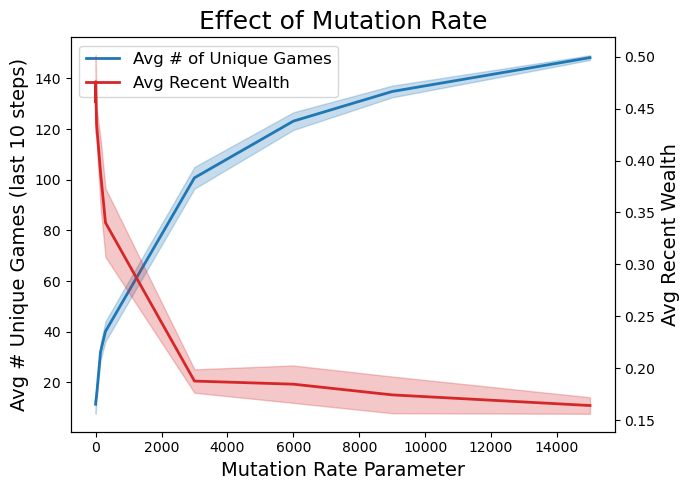

In [11]:
mutation_rw_plot(data_dir="Data/mutation_norm", outname="Figure/mutation_ug_norm.png", last_n=10)

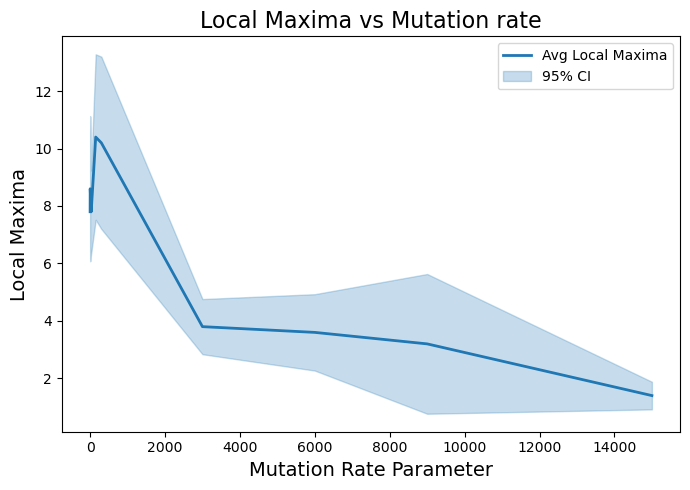

In [14]:
mutation_maxima_plot(data_dir="Data/mutation_norm", outname="Figure/mutation_maxima.png")

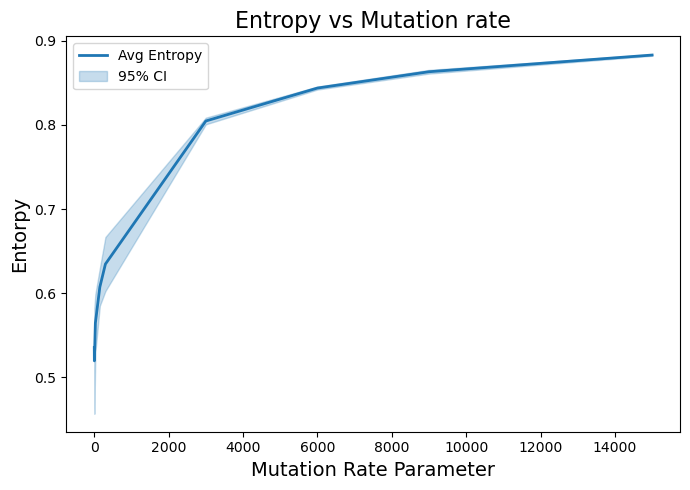

In [12]:
mutation_maxima_plot(data_dir="Data/mutation_norm", outname="Figure/mutation_entropy.png")

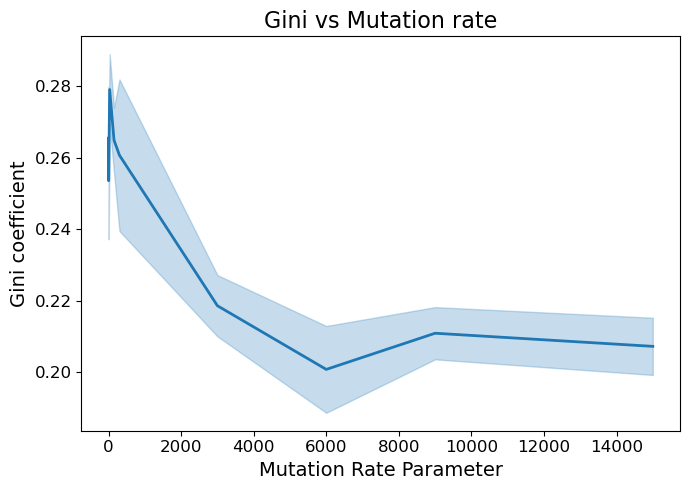

In [15]:
def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    if x_sorted.sum() == 0:
        return 0
    return (np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted))

def lastN_mean_se_gini(df_list, last_n=10):
    vals = [
        df.groupby("Step")["Wealth"].apply(compute_gini).iloc[-last_n:].mean()
        for df in df_list
    ]
    mean = np.mean(vals)
    se = np.std(vals, ddof=1) / np.sqrt(len(vals))
    return mean, se, len(vals)

def mutation_gini_plot(data_dir="Data/mutation", outname="mutation_gini.png", last_n=10):

    pat = re.compile(r"_(\d+(?:\.\d+)?)_")
    agents = {}

    for fp in glob.glob(os.path.join(data_dir, "agent_data_*.csv")):
        rate = float(pat.search(Path(fp).name).group(1))
        agents.setdefault(rate, []).append(pd.read_csv(fp))

    rates = sorted(agents)
    gini_mean, gini_ci = [], []

    for rate in rates:
        dfs_a = agents.get(rate, [])
        m, se, _ = lastN_mean_se_gini(dfs_a, last_n)
        gini_mean.append(m)
        gini_ci.append(1.96*se)

    rates = np.array(rates)
    gini_mean = np.array(gini_mean)
    gini_ci = np.array(gini_ci)

    plt.figure(figsize=(7, 5))
    plt.plot(rates, gini_mean, lw=2)
    plt.fill_between(rates, gini_mean-gini_ci, gini_mean+gini_ci, alpha=0.25, color="tab:blue")
    plt.xlabel("Mutation Rate Parameter", fontsize=14)
    plt.ylabel(f"Gini coefficient", fontsize=14)
    plt.title("Gini vs Mutation rate", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)


mutation_gini_plot(data_dir="Data/mutation_norm", outname="Figure/mutation_gini.png", last_n=10)

## dependence

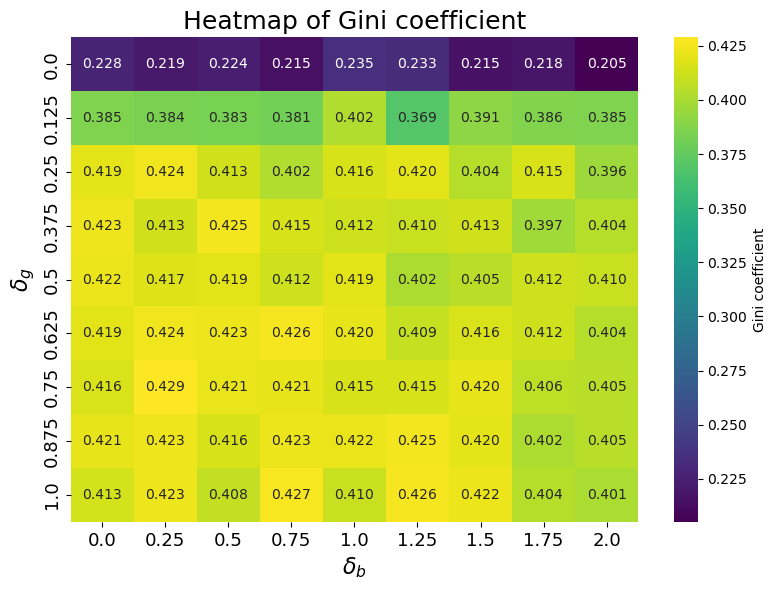

In [16]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    if x_sorted.sum() == 0:
        return 0
    return (np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted))

def extract_dep_and_game(filename):
    pat = re.compile(r"agent_data_([-\d\.]+)_([-\d\.]+)_")
    m = pat.search(os.path.basename(filename))
    if not m:
        raise ValueError(f"Filename does not match pattern: {filename}")
    dep = float(m.group(1))
    dep_game = float(m.group(2))
    return dep, dep_game

def mean_gini_table(data_dir="Data/gini_heatmap"):
    bag = {}
    for f in glob.glob(os.path.join(data_dir, "agent_data_*.csv")):
        dep, dep_game = extract_dep_and_game(f)
        df = pd.read_csv(f)
        gini = compute_gini(df["Wealth"])
        bag.setdefault((dep, dep_game), []).append(gini)
    rows = [
        {"dependence": k[0], "dependence_game": k[1], "gini": np.mean(v)}
        for k, v in bag.items()
    ]
    df = pd.DataFrame(rows)
    return df.pivot(index="dependence_game", columns="dependence", values="gini").sort_index().sort_index(axis=1)

def plot_gini_heatmap(data_dir="Data/gini_heatmap", outname="gini_heatmap.png"):
    table = mean_gini_table(data_dir)
    plt.figure(figsize=(8,6))
    sns.heatmap(table, cmap="viridis", annot=True, fmt=".3f",
                cbar_kws={'label': 'Gini coefficient'})
    plt.title("Heatmap of Gini coefficient", fontsize=18)
    plt.xlabel(r"$\delta_b$", fontsize=16)
    plt.ylabel(r"$\delta_g$", fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)

plot_gini_heatmap(data_dir="Data/dependence_norm", outname="Figure/dependence_norm.png")

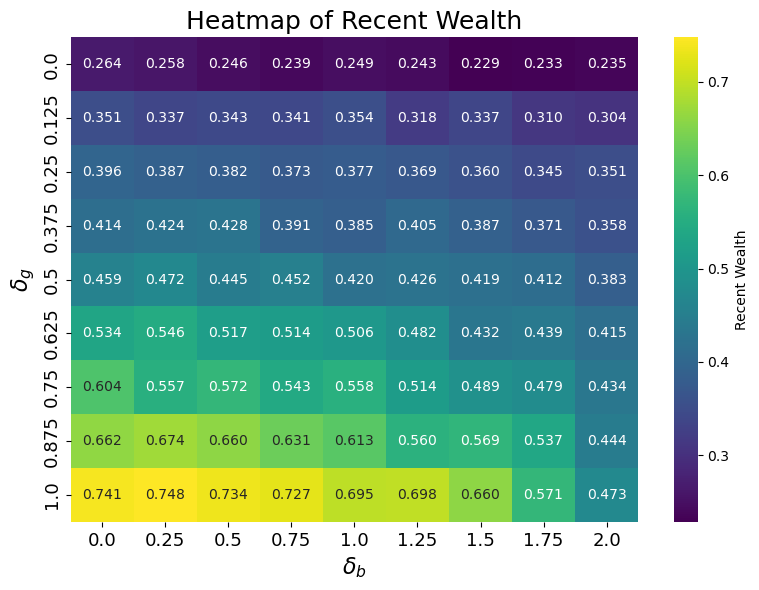

In [17]:
def mean_recentwealth_table(data_dir="Data/gini_heatmap"):
    bag = {}
    for f in glob.glob(os.path.join(data_dir, "agent_data_*.csv")):
        dep, dep_game = extract_dep_and_game(f)
        df = pd.read_csv(f)
        value = df["Recent Wealth"].mean()
        bag.setdefault((dep, dep_game), []).append(value)
    rows = [
        {"dependence": k[0], "dependence_game": k[1], "recent_wealth": np.mean(v)}
        for k, v in bag.items()
    ]
    df = pd.DataFrame(rows)
    return df.pivot(index="dependence_game", columns="dependence", values="recent_wealth")

def plot_recentwealth_heatmap(data_dir="Data/gini_heatmap", outname="recentwealth_heatmap.png"):
    table = mean_recentwealth_table(data_dir)
    plt.figure(figsize=(8,6))
    sns.heatmap(table, cmap="viridis", annot=True, fmt=".3f",
                cbar_kws={'label': 'Recent Wealth'})
    plt.title("Heatmap of Recent Wealth", fontsize=18)
    plt.xlabel(r"$\delta_b$", fontsize=16)
    plt.ylabel(r"$\delta_g$", fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)


plot_recentwealth_heatmap(data_dir="Data/dependence_norm", outname="Figure/dependence_rw_norm.png")

## normalization

In [6]:
import os
import re
import glob
import ast
import seaborn as sns
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from scipy.stats import gaussian_kde, t

In [7]:
def count_local_maxima(u_vals, v_vals, gridsize=40, thr_ratio=0.05):
    pts = np.vstack([u_vals, v_vals])
    kde = gaussian_kde(pts)
    u_lin = np.linspace(min(u_vals), max(u_vals), gridsize)
    v_lin = np.linspace(min(v_vals), max(v_vals), gridsize)
    uu, vv = np.meshgrid(u_lin, v_lin)
    dens = kde(np.vstack([uu.ravel(), vv.ravel()])).reshape(gridsize, gridsize)
    peak_mask = (dens == maximum_filter(dens, size=3, mode='constant'))
    peak_mask &= dens > dens.max() * thr_ratio
    return int(peak_mask.sum())


def local_maxima_mean_se(df_list):
    vals = [
    count_local_maxima(*extract_uv(df["UV"]))
    for df in df_list]
    mean = np.mean(vals)
    se = np.std(vals, ddof=1) / np.sqrt(len(vals))
    return mean, se, len(vals)


def compute_entropy(u_vals, v_vals, gridsize=40):
    pts = np.vstack([u_vals, v_vals])
    kde = gaussian_kde(pts)
    u_lin = np.linspace(min(u_vals), max(u_vals), gridsize)
    v_lin = np.linspace(min(v_vals), max(v_vals), gridsize)
    uu, vv = np.meshgrid(u_lin, v_lin)
    dens = kde(np.vstack([uu.ravel(), vv.ravel()]))
    dens = dens / dens.sum()
    H = -np.sum(dens * np.log(dens + 1e-12))
    H_max = np.log(dens.size)
    return H / H_max   


def compute_entropy_mean_se(df_list):
    vals = [
    compute_entropy(*extract_uv(df["UV"]))
    for df in df_list]
    mean = np.mean(vals)
    se = np.std(vals, ddof=1) / np.sqrt(len(vals))
    return mean, se, len(vals)


def extract_uv(series):
    u_vals, v_vals = [], []
    for item in series:
        u, v = np.nan, np.nan
        if isinstance(item, (tuple, list)):
            u, v = item
        elif isinstance(item, str):
            u, v = ast.literal_eval(item)
        if not (math.isnan(u) or math.isnan(v)):
            u_vals.append(float(u))
            v_vals.append(float(v))
    return u_vals, v_vals


def load_runs(data_dir="Data/local_maxima"):
    pat = re.compile(r"agent_data_([0-9.]+)_")
    runs = {}
    for f in glob.glob(os.path.join(data_dir, "agent_data_*.csv")):
        m = pat.search(os.path.basename(f))
        norm = round(float(m.group(1)), 2)
        runs.setdefault(norm, []).append(pd.read_csv(f))
    return runs

def plot_maxima_vs_norm(data_dir="Data/local_maxima"):
    runs = load_runs(data_dir)

    x_vals, means, ci95 = [], [], []

    for norm in sorted(runs):
        dfs = runs[norm]
        mean, se, n = local_maxima_mean_se(dfs)
        ci = se * t.ppf(0.975, df=n-1) if n > 1 else 0
        x_vals.append(norm)
        means.append(mean)
        ci95.append(ci)

    x_vals = np.array(x_vals)
    means = np.array(means)
    ci95 = np.array(ci95)

    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, means, color='tab:blue', label="Mean Local Maxima", linewidth=2, markersize=6)
    plt.fill_between(x_vals, means - ci95, means + ci95, color='tab:blue', alpha=0.25, label="95% CI")

    plt.xlabel("Normalization", fontsize=16)
    plt.ylabel("Mean # of Local Maxima", fontsize=16)
    plt.title("Local Maxima vs Normalization", fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.savefig("Figure/normalization_local_maxima.png")

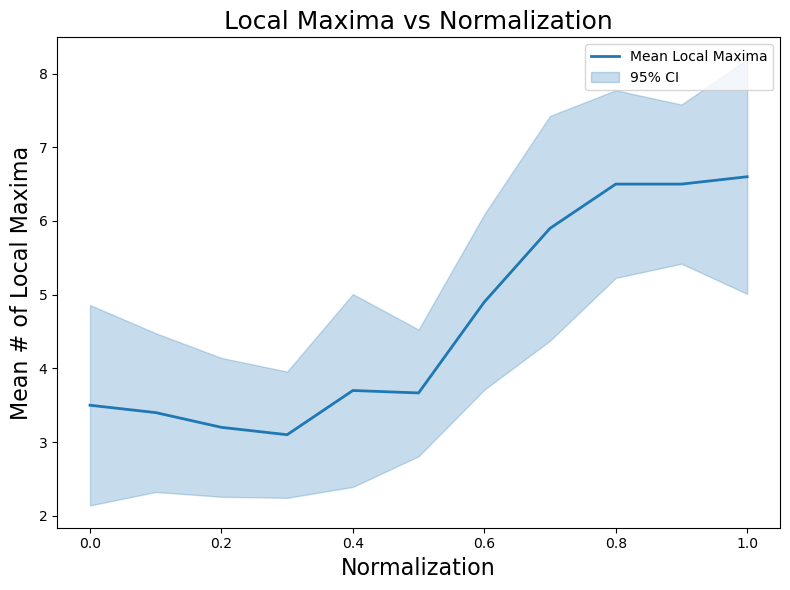

In [18]:
plot_maxima_vs_norm(data_dir="Data/maxima")

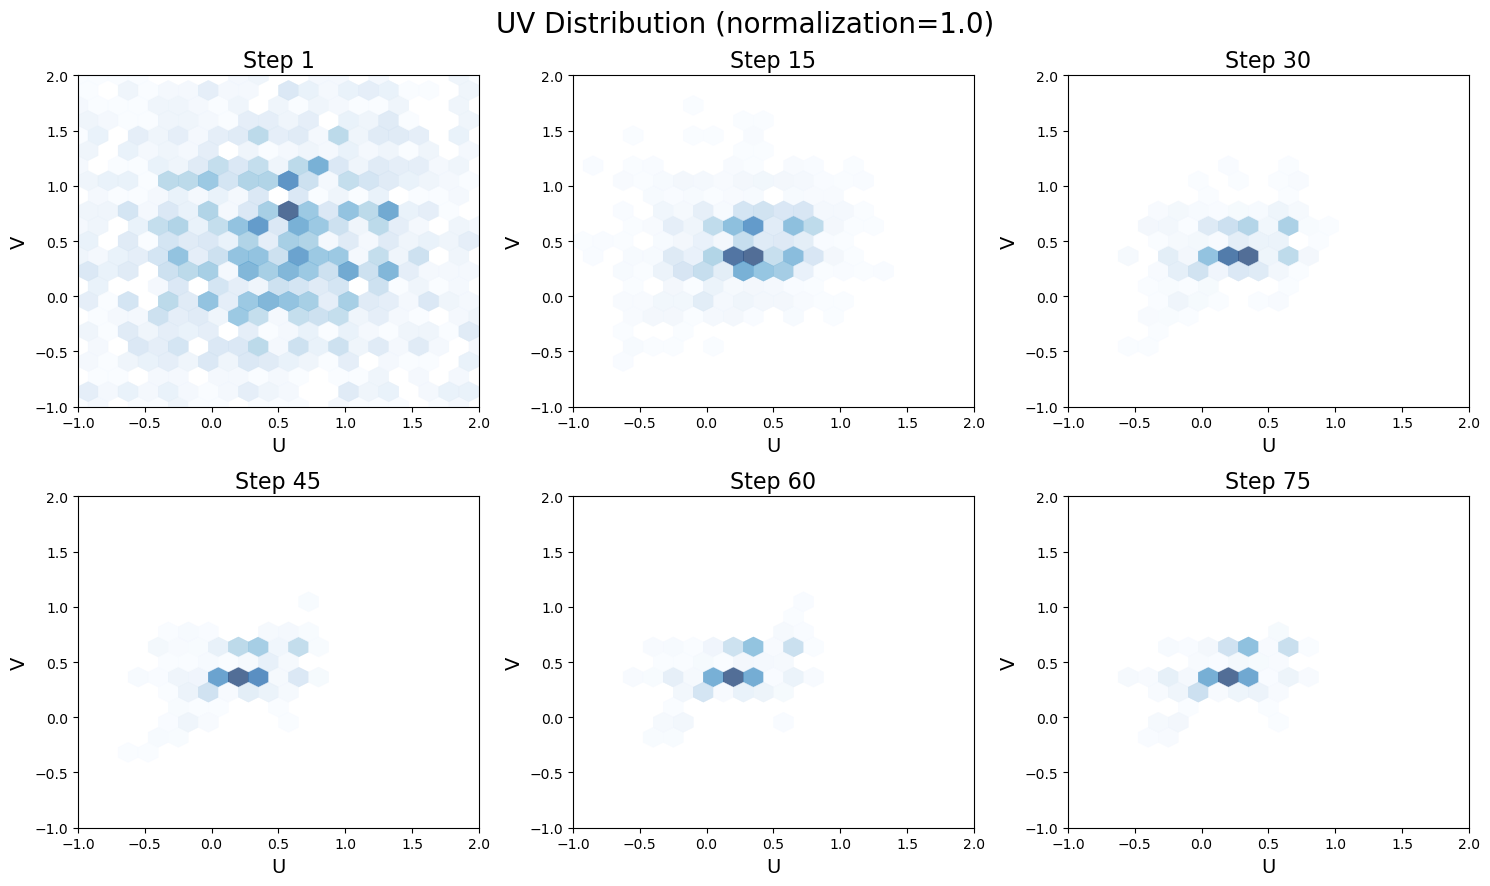

In [11]:
import os, glob, re, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def extract_uv(series):
    u_vals, v_vals = [], []
    for item in series:
        u, v = np.nan, np.nan
        if isinstance(item, (tuple, list)):
            u, v = item
        elif isinstance(item, str):
            u, v = ast.literal_eval(item)
        if not (np.isnan(u) or np.isnan(v)):
            u_vals.append(float(u))
            v_vals.append(float(v))
    return u_vals, v_vals

def get_uv_files(data_dir, target_value="0.0"):
    pat = re.compile(r"agent_data_({})_".format(re.escape(target_value)))
    file_list = []
    for f in glob.glob(os.path.join(data_dir, "agent_data_*.csv")):
        if pat.search(os.path.basename(f)):
            file_list.append(f)
    return file_list

def plot_uv_hexbin_subplots(
    data_dir="Data/uv_snapshots",
    target_value="0.0",
    steps=[1, 40, 80, 120, 160, 190],
    outname="uv_hexbin_0.0.png"
):
    files = get_uv_files(data_dir, target_value=target_value)
    if not files:
        print("No files found!")
        return

    dfs = [pd.read_csv(f) for f in files]
    nrow, ncol = 2, 3
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 9))
    axes = axes.flatten()

    umin, umax, vmin, vmax = -1, 2, -1, 2

    for idx, step in enumerate(steps):
        u_all, v_all = [], []
        for df in dfs:
            if step in df["Step"].values:
                sub = df[df["Step"] == step]
                u, v = extract_uv(sub["UV"])
                u_all.extend(u)
                v_all.extend(v)

        ax = axes[idx]
        hb = ax.hexbin(
            u_all, v_all,
            gridsize=20,
            extent=(umin, umax, vmin, vmax),
            cmap="Blues",
            mincnt=1,
            linewidths=0.3,
            alpha=0.7
        )
        ax.set_xlim(umin, umax)
        ax.set_ylim(vmin, vmax)
        ax.set_title(f"Step {step}", fontsize=16)
        ax.set_xlabel("U", fontsize=14)
        ax.set_ylabel("V", fontsize=14)

    fig.suptitle(f"UV Distribution (normalization={target_value})", fontsize=20)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)

plot_uv_hexbin_subplots(data_dir="Data/maxima", target_value="1.0", steps=[1, 15, 30, 45, 60, 75], outname="Figure/uv_hexbin_1.0.png")

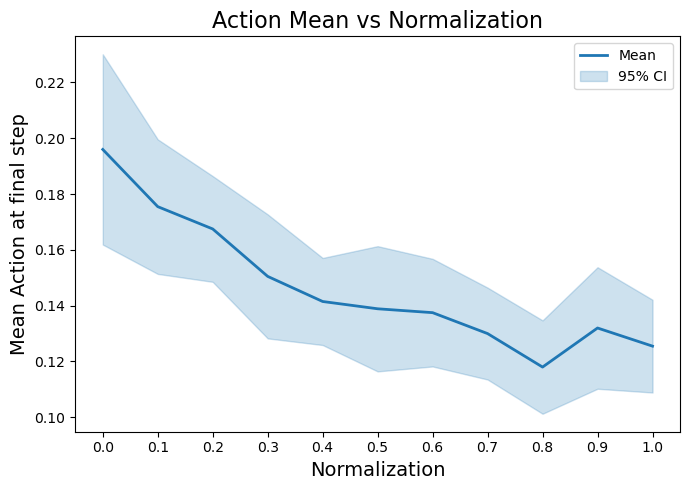

In [19]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def extract_normalization(filename):
    m = re.search(r"agent_data_([-\d\.]+)_", os.path.basename(filename))
    if not m:
        raise ValueError(f"Filename not matched: {filename}")
    return float(m.group(1))

def get_action_mean_laststep(filepath):
    df = pd.read_csv(filepath)
    last_step = df["Step"].max()
    actions = df[df["Step"] == last_step]["Action"]
    return actions.mean()

def plot_action_vs_normalization(data_dir="Data/uv_snapshots", outname="action_vs_norm.png"):
    file_list = glob.glob(os.path.join(data_dir, "agent_data_*.csv"))
    norm_to_means = defaultdict(list)

    for fp in file_list:
        norm = extract_normalization(fp)
        mean_action = get_action_mean_laststep(fp)
        norm_to_means[norm].append(mean_action)

    norm_levels = sorted(norm_to_means)
    means = []
    errors = []
    for norm in norm_levels:
        vals = norm_to_means[norm]
        m = np.mean(vals)
        se = np.std(vals, ddof=1) / np.sqrt(len(vals)) if len(vals) > 1 else 0
        means.append(m)
        errors.append(1.96 * se)

    norm_levels = np.array(norm_levels)
    means = np.array(means)
    errors = np.array(errors)

    plt.figure(figsize=(7,5))
    plt.plot(norm_levels, means, lw=2, color="tab:blue", label="Mean")
    plt.fill_between(norm_levels, means - errors, means + errors, color="tab:blue", alpha=0.22, label="95% CI")
    plt.xlabel("Normalization", fontsize=14)
    plt.ylabel("Mean Action at final step", fontsize=14)
    plt.title("Action Mean vs Normalization", fontsize=16)
    plt.xticks(norm_levels)
    plt.tight_layout()
    plt.legend()
    plt.savefig(outname, dpi=150)

plot_action_vs_normalization(data_dir="Data/maxima", outname="Figure/action_vs_norm.png")

## exponential fit

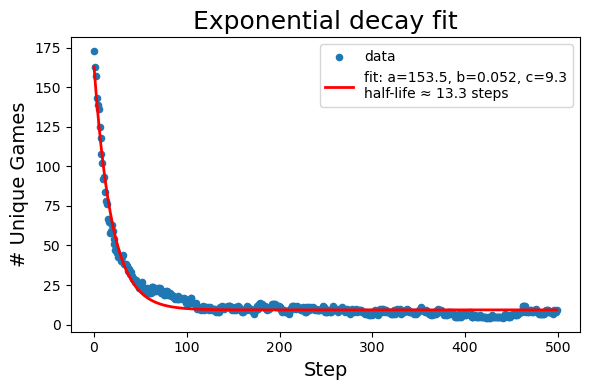

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def parse_ug(entry):
    if isinstance(entry, str):
        return ast.literal_eval(entry)
    return entry if isinstance(entry, list) else []

def ug_series(model_df):
    df = model_df.copy()
    df["UG_left"] = df["Unique Games"].apply(lambda x: len(parse_ug(x)))
    return df.set_index("Step")["UG_left"]

def exp_decay(t, a, b, c):
    return a * np.exp(-b * t) + c

model_data = pd.read_csv("Data/500steps_norm/model_data.csv")
series = ug_series(model_data)
t = series.index.values
y = series.values

c0 = y[-5:].mean()
p0 = [y[0]-c0, 0.01, c0]

popt, pcov = curve_fit(exp_decay, t, y, p0, maxfev=10000)
a_fit, b_fit, c_fit = popt
half_life = np.log(2)/b_fit

t_fine = np.linspace(t.min(), t.max(), 400)
y_fit = exp_decay(t_fine, *popt)

plt.figure(figsize=(6,4))
plt.scatter(t, y, s=20, label="data")
plt.plot(t_fine, y_fit, 'r', lw=2, label=f"fit: a={a_fit:.1f}, b={b_fit:.3f}, c={c_fit:.1f}\n"
                                           f"half-life ≈ {half_life:.1f} steps")
plt.xlabel("Step", fontsize=14)
plt.ylabel("# Unique Games", fontsize=14)
plt.title("Exponential decay fit", fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig("Figure/exponential_fit.png", dpi=150)

## Extra: drift

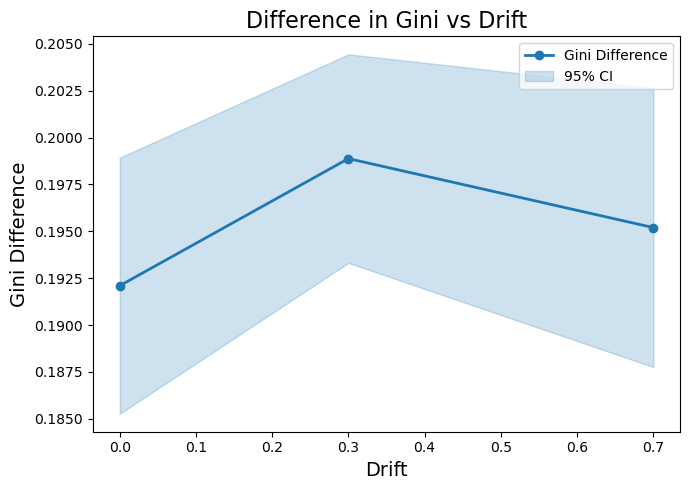

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, glob, re
import pandas as pd
from collections import defaultdict

def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    if x_sorted.sum() == 0:
        return 0
    return (np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted))


def load_runs_drift(data_dir):
    files = glob.glob(os.path.join(data_dir, "agent_data_*.csv"))
    pattern = re.compile(r"agent_data(_null)?_([-\d\.]+)_")
    runs = {"Default": defaultdict(list), "Null": defaultdict(list)}

    for f in files:
        fname = os.path.basename(f)
        m = pattern.search(fname)
        if not m:
            continue
        is_null = m.group(1) is not None
        drift = float(m.group(2))
        df = pd.read_csv(f)
        key = "Null" if is_null else "Default"
        runs[key][drift].append(df)
    return runs


def avg_final_gini(df_list):
    ginis = []
    for df in df_list:
        last_step = df["Step"].max()
        sub = df[df["Step"] == last_step]
        g = compute_gini(sub["Wealth"])
        ginis.append(g)
    mean = np.mean(ginis)
    se = np.std(ginis, ddof=1) / np.sqrt(len(ginis)) if len(ginis) > 1 else 0
    return mean, se

def plot_gini_diff_vs_drift(data_dir, outname="gini_diff_vs_drift.png"):
    runs = load_runs_drift(data_dir)
    all_drifts = sorted(set(runs["Default"].keys()).intersection(runs["Null"].keys()))
    drift_vals = []
    gini_diff = []
    gini_diff_se = []

    for drift in all_drifts:
        mean_def, se_def = avg_final_gini(runs["Default"][drift])
        mean_null, se_null = avg_final_gini(runs["Null"][drift])
        diff = mean_def - mean_null
        se = np.sqrt(se_def**2 + se_null**2)
        drift_vals.append(drift)
        gini_diff.append(diff)
        gini_diff_se.append(1.96 * se)

    drift_vals = np.array(drift_vals)
    gini_diff = np.array(gini_diff)
    gini_diff_se = np.array(gini_diff_se)
    idx = np.argsort(drift_vals)
    drift_vals = drift_vals[idx]
    gini_diff = gini_diff[idx]
    gini_diff_se = gini_diff_se[idx]

    plt.figure(figsize=(7,5))
    plt.plot(drift_vals, gini_diff, marker="o", lw=2, color="tab:blue", label="Gini Difference")
    plt.fill_between(drift_vals, gini_diff - gini_diff_se, gini_diff + gini_diff_se, color="tab:blue", alpha=0.22, label="95% CI")
    plt.xlabel("Drift", fontsize=14)
    plt.ylabel("Gini Difference", fontsize=14)
    plt.title("Difference in Gini vs Drift", fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outname, dpi=150)


plot_gini_diff_vs_drift(data_dir="data/drift", outname="drift_diff.png")


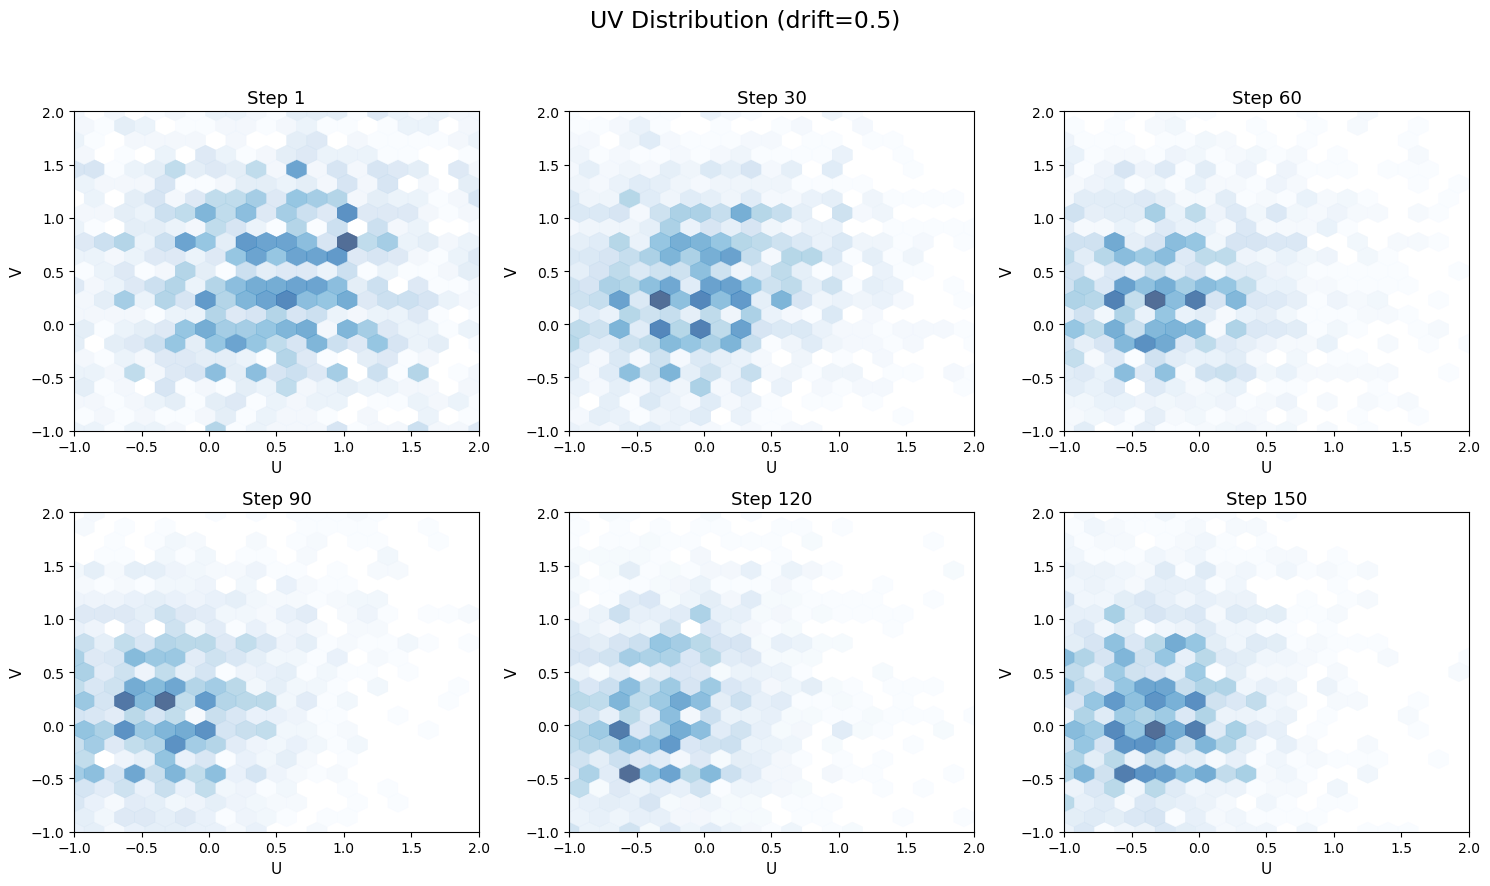

In [5]:
import os, glob, re, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def extract_uv(series):
    u_vals, v_vals = [], []
    for item in series:
        u, v = np.nan, np.nan
        if isinstance(item, (tuple, list)):
            u, v = item
        elif isinstance(item, str):
            u, v = ast.literal_eval(item)
        if not (np.isnan(u) or np.isnan(v)):
            u_vals.append(float(u))
            v_vals.append(float(v))
    return u_vals, v_vals

def get_uv_files(data_dir, target_value="0.0"):
    pat = re.compile(r"agent_data_({})_".format(re.escape(target_value)))
    file_list = []
    for f in glob.glob(os.path.join(data_dir, "agent_data_*.csv")):
        if pat.search(os.path.basename(f)):
            file_list.append(f)
    return file_list

def plot_uv_hexbin_subplots(
    data_dir="Data/uv_snapshots",
    target_value="0.0",
    steps=[1, 40, 80, 120, 160, 190],
    outname="uv_hexbin_0.0.png"
):
    files = get_uv_files(data_dir, target_value=target_value)
    if not files:
        print("No files found!")
        return

    dfs = [pd.read_csv(f) for f in files]
    nrow, ncol = 2, 3
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 9))
    axes = axes.flatten()

    umin, umax, vmin, vmax = -1, 2, -1, 2

    for idx, step in enumerate(steps):
        u_all, v_all = [], []
        for df in dfs:
            if step in df["Step"].values:
                sub = df[df["Step"] == step]
                u, v = extract_uv(sub["UV"])
                u_all.extend(u)
                v_all.extend(v)

        ax = axes[idx]
        hb = ax.hexbin(
            u_all, v_all,
            gridsize=20,
            extent=(umin, umax, vmin, vmax),
            cmap="Blues",
            mincnt=1,
            linewidths=0.3,
            alpha=0.7
        )
        ax.set_xlim(umin, umax)
        ax.set_ylim(vmin, vmax)
        ax.set_title(f"Step {step}", fontsize=13)
        ax.set_xlabel("U", fontsize=11)
        ax.set_ylabel("V", fontsize=11)

    fig.suptitle(f"UV Distribution (drift={target_value})", fontsize=17)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(outname, dpi=150)
    # plt.show()

plot_uv_hexbin_subplots(data_dir="Data/drift_norm", target_value="0.5", steps=[1, 30, 60, 90, 120, 150], outname="uv_drift_0.5.png")

## sigma & drift

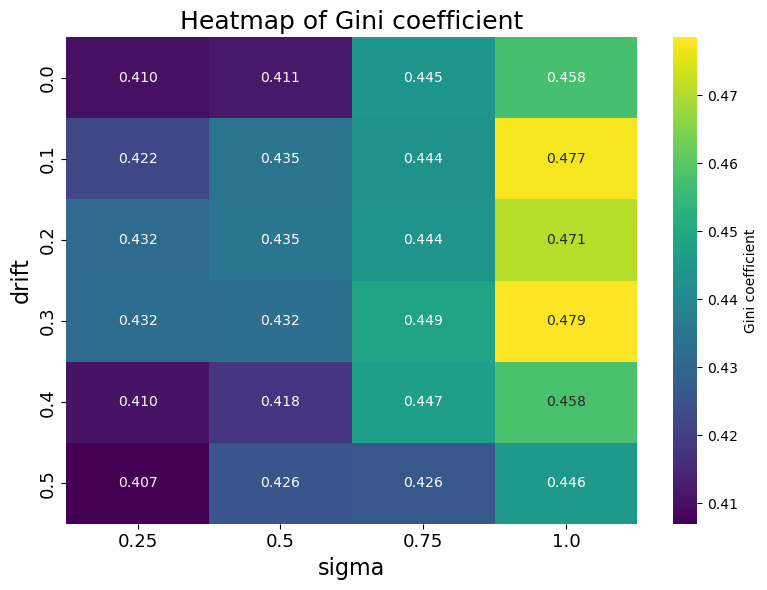

In [3]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    if x_sorted.sum() == 0:
        return 0
    return (np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted))

def extract_sigma_and_drift(filename):
    pat = re.compile(r"agent_data_sigma([-\d\.]+)_drift([-\d\.]+)_")
    m = pat.search(os.path.basename(filename))
    sigma = float(m.group(1))
    drift = float(m.group(2))
    return sigma, drift

def mean_gini_table(data_dir="Data/gini_heatmap"):
    bag = {}
    for f in glob.glob(os.path.join(data_dir, "agent_data_*.csv")):
        sigma, drift = extract_sigma_and_drift(f)
        df = pd.read_csv(f)
        gini = compute_gini(df["Wealth"])
        bag.setdefault((sigma, drift), []).append(gini)
    rows = [
        {"sigma": k[0], "drift": k[1], "gini": np.mean(v)}
        for k, v in bag.items()
    ]
    df = pd.DataFrame(rows)
    return df.pivot(index="drift", columns="sigma", values="gini").sort_index().sort_index(axis=1)

def plot_gini_heatmap(data_dir="Data/gini_heatmap", outname="gini_heatmap.png"):
    table = mean_gini_table(data_dir)
    plt.figure(figsize=(8,6))
    sns.heatmap(table, cmap="viridis", annot=True, fmt=".3f",
                cbar_kws={'label': 'Gini coefficient'})
    plt.title("Heatmap of Gini coefficient", fontsize=18)
    plt.xlabel("sigma", fontsize=16)
    plt.ylabel("drift", fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)

plot_gini_heatmap(data_dir="Data/sigma_drift_norm", outname="sigma_drift_norm.png")

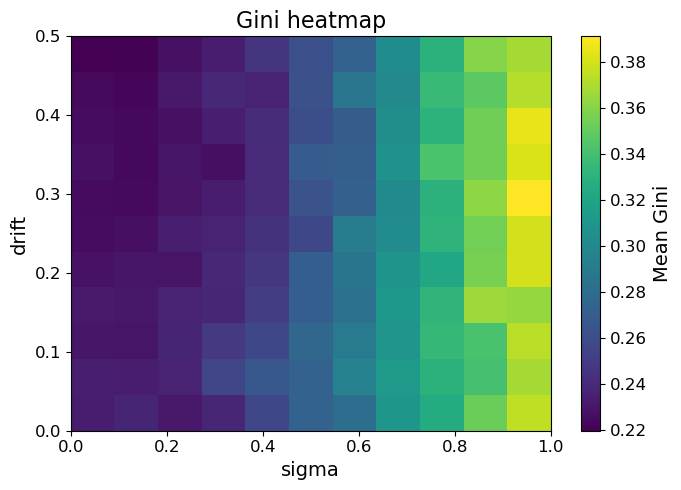

In [4]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 读取所有文件的最后一行 Gini
def read_gini_last(data_dir, gini_col="Gini Coefficient"):

    regex_list = [
        re.compile(r"model_data_([0-9.]+)_([0-9.]+)_rep(\d+)\.csv$"),
        re.compile(r"model_data_([0-9.]+)_([0-9.]+)\)_rep(\d+)\.csv$"),
    ]

    rows = []
    for fp in glob.glob(os.path.join(data_dir, "model_data_*_rep*.csv")):
        fname = os.path.basename(fp)
        drift = sigma = rep = None
        for rgx in regex_list:
            m = rgx.match(fname)
            if m:
                drift, sigma, rep = m.groups()
                break
        if m is None:
            continue

        drift = float(drift)
        sigma = float(sigma)
        rep = int(rep)

        try:
            df = pd.read_csv(fp)
            # 取该列最后一个非空值
            if gini_col not in df.columns:
                # 如果列名不同，可在这里做个兜底别名
                # gini_col_alt = "Gini"  # 举例
                # gini_val = df[gini_col_alt].dropna().iloc[-1]
                raise KeyError(f"Column '{gini_col}' not found in {fname}")
            gini_val = df[gini_col].dropna().iloc[-1]
            rows.append({"drift": drift, "sigma": sigma, "rep": rep, "gini_last": float(gini_val)})
        except Exception as e:
            print(f"skip {fname}: {e}")

    return pd.DataFrame(rows)

def plot_gini_heatmap(df, outname="gini_heatmap.png"):
    """
    df: 包含 columns = [drift, sigma, rep, gini_last]
    横轴：sigma，纵轴：drift，值：同一(drift,sigma)下20个rep的均值
    """
    # 计算均值
    mean_df = (df.groupby(["drift", "sigma"])["gini_last"]
                 .mean()
                 .reset_index(name="gini_mean"))

    # 构建网格
    drift_vals = np.sort(mean_df["drift"].unique())
    sigma_vals = np.sort(mean_df["sigma"].unique())
    grid = np.full((len(drift_vals), len(sigma_vals)), np.nan)

    # 填充均值
    drift_index = {v: i for i, v in enumerate(drift_vals)}
    sigma_index = {v: i for i, v in enumerate(sigma_vals)}
    for _, row in mean_df.iterrows():
        i = drift_index[row["drift"]]
        j = sigma_index[row["sigma"]]
        grid[i, j] = row["gini_mean"]

    # 画图
    plt.figure(figsize=(7, 5))
    im = plt.imshow(
        grid,
        origin="lower",
        aspect="auto",
        extent=[sigma_vals.min(), sigma_vals.max(), drift_vals.min(), drift_vals.max()]
    )
    cbar = plt.colorbar(im)
    cbar.set_label("Mean Gini", fontsize=14)  # 颜色条标题大字体
    cbar.ax.tick_params(labelsize=12)  # 颜色条刻度字体

    plt.xlabel("sigma", fontsize=14)
    plt.ylabel("drift", fontsize=14)
    plt.title("Gini heatmap", fontsize=16)

    # 每隔两个值显示一次刻度
    if len(sigma_vals) <= 15:
        plt.xticks(sigma_vals[::2], fontsize=12)
    else:
        plt.xticks(np.linspace(sigma_vals.min(), sigma_vals.max(), 6), fontsize=12)

    if len(drift_vals) <= 15:
        plt.yticks(drift_vals[::2], fontsize=12)
    else:
        plt.yticks(np.linspace(drift_vals.min(), drift_vals.max(), 6), fontsize=12)

    plt.tight_layout()
    plt.savefig(outname, dpi=150)



data_dir = "Data/drift_sigma"
df_gini = read_gini_last(data_dir, gini_col="Gini Coefficient")
plot_gini_heatmap(df_gini, outname="gini_heatmap.png")


## Pareto

model_data_rewiring_p_0.500_alpha_0.000_rat_2.000_risk_0.000_normalizeGames_0.300_dependence_0.333_dependence_game_0.300.csv (utility = 3.116873782682114)
model_data_rewiring_p_0.300_alpha_0.667_rat_1.333_risk_1.333_normalizeGames_0.700_dependence_1.000_dependence_game_0.767.csv (utility = 9.163568722751371)
model_data_rewiring_p_0.500_alpha_0.000_rat_2.000_risk_2.000_normalizeGames_0.700_dependence_1.000_dependence_game_0.767.csv (utility = 5.853257285772588)
model_data_rewiring_p_0.500_alpha_0.333_rat_1.667_risk_0.000_normalizeGames_0.500_dependence_0.333_dependence_game_0.533.csv (utility = 5.029237600087214)
model_data_rewiring_p_0.200_alpha_0.667_rat_1.333_risk_2.000_normalizeGames_0.300_dependence_0.000_dependence_game_0.300.csv (utility = 4.318403788184444)
model_data_rewiring_p_0.500_alpha_0.667_rat_1.333_risk_1.333_normalizeGames_0.300_dependence_1.000_dependence_game_0.300.csv (utility = 6.203313582233543)
model_data_rewiring_p_0.200_alpha_0.667_rat_2.000_risk_2.000_normalize

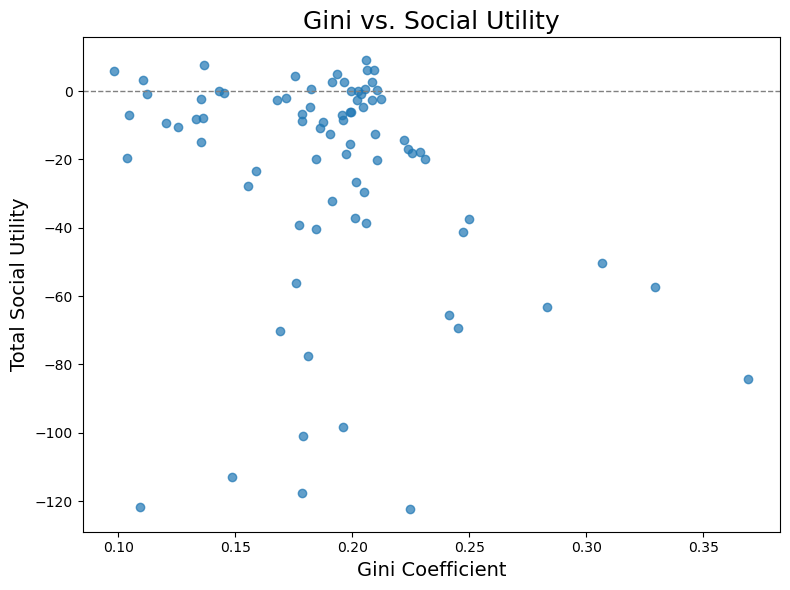

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


data_dir = Path('Data/pareto')
files = [f for f in data_dir.glob('model_data_*.csv')]

gini_values = []
utility_values = []

for file in files:
    df = pd.read_csv(file)
    last_row = df.iloc[-1]
    gini = last_row['Gini Coefficient']
    utility = last_row['Total Social Utility']
    # if utility < 0:
        # print(f"Skipping file with negative utility: {file.name} (utility = {utility})")
        # continue
    if utility > 0:
        print(f"{file.name} (utility = {utility})")
    gini_values.append(gini)
    utility_values.append(utility)


plt.figure(figsize=(8, 6))
plt.scatter(gini_values, utility_values, alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Gini Coefficient", fontsize=14)
plt.ylabel("Total Social Utility", fontsize=14)
plt.title("Gini vs. Social Utility", fontsize=18)
plt.tight_layout()
plt.savefig("Figure/pareto_gsa.png", dpi=150)


## Pareto plus

In [8]:
import re
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, ks_2samp, mannwhitneyu

DATA_DIR = Path("Data/pareto_plus")
OUT_DIR = Path("Figure/param_distributions")
FILENAME_GLOB = "model_data_*.csv"
DPI = 140

latex_labels = {
    "alpha": r"$\alpha$",
    "dependence": r"$\delta_b$",
    "dependence_game": r"$\delta_g$",
    "normalizeGames": r"$\omega$",
    "rat": r"$\lambda$",
    "risk": r"$\eta$",
    "rewiring_p": r"$p_{\mathrm{rewire}}$"
}

PARAM_KEYS = [
    "rewiring_p", "alpha", "rat", "risk",
    "normalizeGames", "dependence", "dependence_game"
]

param_patterns = {k: re.compile(rf"{k}_([-\d\.]+)") for k in PARAM_KEYS}

def parse_params_from_name(name: str) -> dict:
    params = {}
    for k, pat in param_patterns.items():
        m = pat.search(name)
        if m is None:
            raise ValueError(f"Parameter '{k}' not found in filename: {name}")
        v = float(m.group(1))
        params[k] = v
    return params

def kde_curve(x: np.ndarray, num_points: int = 256):
    x = np.asarray(x, dtype=float)
    xmin, xmax = np.min(x), np.max(x)
    if math.isclose(xmin, xmax):
        xmin -= 1e-9
        xmax += 1e-9
    padding = 0.05 * (xmax - xmin) if xmax > xmin else 0.05
    grid = np.linspace(xmin - padding, xmax + padding, num_points)
    kde = gaussian_kde(x)
    y = kde(grid)
    return grid, y, (xmin - padding, xmax + padding)

# ========= Load & Split =========
files = sorted(DATA_DIR.glob(FILENAME_GLOB))
if len(files) == 0:
    raise FileNotFoundError(f"No files found matching {FILENAME_GLOB} under {DATA_DIR}")

records = []
for fp in files:
    df = pd.read_csv(fp)
    last = df.iloc[-1]
    utility = float(last["Total Social Utility"])
    row = parse_params_from_name(fp.name)
    row["utility"] = utility
    row["label"] = "Good" if utility > 0 else "Bad"
    records.append(row)

runs = pd.DataFrame.from_records(records)

n_good = (runs["label"] == "Good").sum()
n_bad = (runs["label"] == "Bad").sum()
print(f"Loaded {len(runs)} runs. Good={n_good}, Bad={n_bad}")

OUT_DIR.mkdir(parents=True, exist_ok=True)

# ========= Stats & Plots per parameter (KDE only) =========
summary_rows = []
compare_params = [k for k in PARAM_KEYS if k != "rep"]

for param in compare_params:
    good = runs.loc[runs["label"] == "Good", param].astype(float).to_numpy()
    bad  = runs.loc[runs["label"] == "Bad",  param].astype(float).to_numpy()

    # Basic stats
    g_mean, b_mean = np.mean(good), np.mean(bad)
    g_med,  b_med  = np.median(good), np.median(bad)
    g_std,  b_std  = np.std(good, ddof=1), np.std(bad, ddof=1)

    # KS and Mann-Whitney (guard against empty groups)
    if len(good) > 0 and len(bad) > 0:
        ks_stat, ks_p = ks_2samp(good, bad, alternative="two-sided", mode="auto")
        mw_u, mw_p = mannwhitneyu(good, bad, alternative="two-sided")
    else:
        ks_stat, ks_p, mw_u, mw_p = np.nan, np.nan, np.nan, np.nan

    summary_rows.append({
        "parameter": param,
        "n_good": len(good),
        "n_bad": len(bad),
        "good_mean": g_mean,
        "bad_mean": b_mean,
        "good_median": g_med,
        "bad_median": b_med,
        "good_std": g_std,
        "bad_std": b_std,
        "ks_stat": ks_stat,
        "ks_p": ks_p,
        "mw_u": mw_u,
        "mw_p": mw_p,
    })

    # ---------- Plot: KDE only ----------
    fig, ax = plt.subplots(1, 1, figsize=(8.5, 4.8), dpi=DPI)

    xlim = None
    has_good_kde = len(good) >= 2
    has_bad_kde  = len(bad)  >= 2

    if has_good_kde:
        gx, gy, (gmin, gmax) = kde_curve(good)
        ax.plot(gx, gy, label="Good")
        xlim = (gmin, gmax) if xlim is None else (min(xlim[0], gmin), max(xlim[1], gmax))
    else:
        ax.scatter(good, np.zeros_like(good), alpha=0.7, label="Good")

    if has_bad_kde:
        bx, by, (bmin, bmax) = kde_curve(bad)
        ax.plot(bx, by, label="Bad")
        xlim = (bmin, bmax) if xlim is None else (min(xlim[0], bmin), max(xlim[1], bmax))
    else:
        ax.scatter(bad, np.zeros_like(bad), alpha=0.7, label="Bad")

    if xlim is not None:
        ax.set_xlim(xlim)

    label_str = latex_labels.get(param, param)
    ax.set_title(f"{label_str} — KDE | KS p={ks_p:.3g} | MW p={mw_p:.3g}", fontsize=16)
    ax.set_xlabel(label_str, fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.legend()

    fig.tight_layout()
    fig.savefig(OUT_DIR / f"{param}_good_vs_bad.png")
    plt.close(fig)

# ========= Save stats (no Cliff's delta) =========
summary = pd.DataFrame(summary_rows)
summary = summary.sort_values(by=["ks_p", "mw_p"], ascending=[True, True])
summary.to_csv(OUT_DIR / "param_diff_stats.csv", index=False)

# Print a quick top-5 by KS p-value, then by MW p-value
print("\nTop-5 by KS p-value:")
print(summary.nsmallest(5, "ks_p")[["parameter", "ks_stat", "ks_p", "mw_p"]])

print("\nTop-5 by MW p-value:")
print(summary.nsmallest(5, "mw_p")[["parameter", "mw_u", "mw_p", "ks_p"]])

print(f"\nDone. Figures -> {OUT_DIR}, stats -> {OUT_DIR / 'param_diff_stats.csv'}")

Loaded 1023 runs. Good=297, Bad=726

Top-5 by KS p-value:
         parameter   ks_stat          ks_p          mw_p
6  dependence_game  0.335170  1.650451e-21  4.112132e-22
4   normalizeGames  0.131466  1.222588e-03  4.589130e-02
3             risk  0.113866  7.708556e-03  1.908496e-02
2              rat  0.112489  8.804480e-03  2.026685e-02
5       dependence  0.059535  4.251035e-01  2.285486e-01

Top-5 by MW p-value:
         parameter      mw_u          mw_p          ks_p
6  dependence_game   66338.5  4.112132e-22  1.650451e-21
3             risk   97756.5  1.908496e-02  7.708556e-03
2              rat  117769.0  2.026685e-02  8.804480e-03
4   normalizeGames   99247.0  4.589130e-02  1.222588e-03
5       dependence  102645.5  2.285486e-01  4.251035e-01

Done. Figures -> Figure/param_distributions, stats -> Figure/param_distributions/param_diff_stats.csv


## Clean data

In [7]:
import re, pandas as pd
from pathlib import Path

_float_pat = re.compile(
    r"np\.float(?:32|64)?\(\s*([-+]?[\d\.]+(?:[eE][-+]?\d+)?)\s*\)"
)
def strip_np_float(txt: str) -> str:
    return _float_pat.sub(r"\1", txt)

base_dir = Path("Data/maxima")

for csv_path in base_dir.rglob("agent_data_*.csv"):
    df = pd.read_csv(csv_path, dtype=str)
    if "UV" in df.columns:
        df["UV"] = df["UV"].apply(strip_np_float)
        df.to_csv(csv_path, index=False)
        print(f"cleaned → {csv_path}")

# for csv_path in base_dir.rglob("model_data_*.csv"):
#     df = pd.read_csv(csv_path, dtype=str)
#     if "Unique Games" in df.columns:
#         df["Unique Games"] = df["Unique Games"].apply(strip_np_float)
#         df.to_csv(csv_path, index=False)
#         print(f"cleaned → {csv_path}")


cleaned → Data/maxima/agent_data_0.6_rep4.csv
cleaned → Data/maxima/agent_data_0.7_rep4.csv
cleaned → Data/maxima/agent_data_0.7_rep5.csv
cleaned → Data/maxima/agent_data_0.6_rep5.csv
cleaned → Data/maxima/agent_data_0.7_rep7.csv
cleaned → Data/maxima/agent_data_0.6_rep7.csv
cleaned → Data/maxima/agent_data_0.6_rep6.csv
cleaned → Data/maxima/agent_data_0.7_rep6.csv
cleaned → Data/maxima/agent_data_0.3_rep8.csv
cleaned → Data/maxima/agent_data_0.2_rep8.csv
cleaned → Data/maxima/agent_data_0.7_rep2.csv
cleaned → Data/maxima/agent_data_0.6_rep2.csv
cleaned → Data/maxima/agent_data_0.6_rep3.csv
cleaned → Data/maxima/agent_data_0.7_rep3.csv
cleaned → Data/maxima/agent_data_0.2_rep9.csv
cleaned → Data/maxima/agent_data_0.3_rep9.csv
cleaned → Data/maxima/agent_data_1.0_rep8.csv
cleaned → Data/maxima/agent_data_0.9_rep8.csv
cleaned → Data/maxima/agent_data_0.8_rep8.csv
cleaned → Data/maxima/agent_data_0.6_rep1.csv
cleaned → Data/maxima/agent_data_0.7_rep1.csv
cleaned → Data/maxima/agent_data_0

## GSA

In [4]:
import os, ast, re, math
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from SALib.analyze import morris
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
from scipy.ndimage import maximum_filter, gaussian_filter

In [5]:
def extract_uv(series):
    u_vals, v_vals = [], []
    for item in series:
        u, v = np.nan, np.nan
        if isinstance(item, (tuple, list)):
            u, v = item
        elif isinstance(item, str):
            u, v = ast.literal_eval(item)
        if not (math.isnan(u) or math.isnan(v)):
            u_vals.append(float(u))
            v_vals.append(float(v))
    return u_vals, v_vals


def _grid_density(u_vals, v_vals, gridsize=40):
    u_vals = np.asarray(u_vals, dtype=float)
    v_vals = np.asarray(v_vals, dtype=float)
    n = len(u_vals)

    if n < 5 or np.isclose(np.std(u_vals), 0.0) or np.isclose(np.std(v_vals), 0.0):
        H, _, _ = np.histogram2d(u_vals, v_vals, bins=gridsize)
        dens = H / H.sum() if H.sum() > 0 else np.zeros((gridsize, gridsize))
        if H.sum() > 0:
            dens = gaussian_filter(dens, sigma=1.0)
            dens = dens / dens.sum()
        return dens

    try:
        pts = np.vstack([u_vals, v_vals])
        kde = gaussian_kde(pts)
        u_lin = np.linspace(u_vals.min(), u_vals.max(), gridsize)
        v_lin = np.linspace(v_vals.min(), v_vals.max(), gridsize)
        uu, vv = np.meshgrid(u_lin, v_lin, indexing="xy")
        dens = kde(np.vstack([uu.ravel(), vv.ravel()])).reshape(gridsize, gridsize)
        s = dens.sum()
        if s <= 0 or not np.isfinite(s):
            raise RuntimeError("KDE produced non-positive sum")
        return dens / s
    except Exception:
        H, _, _ = np.histogram2d(u_vals, v_vals, bins=gridsize)
        dens = H / H.sum() if H.sum() > 0 else np.zeros((gridsize, gridsize))
        if H.sum() > 0:
            dens = gaussian_filter(dens, sigma=1.0)
            dens = dens / dens.sum()
        return dens


def compute_entropy(u_vals, v_vals, gridsize=40):
    dens2d = _grid_density(u_vals, v_vals, gridsize=gridsize)
    p = dens2d.ravel()
    H = -np.sum(p * np.log(p + 1e-12))
    H_max = np.log(p.size)
    return float(H / H_max) if H_max > 0 else 0.0


def count_local_maxima(u_vals, v_vals, gridsize=40, thr_ratio=0.05):
    dens2d = _grid_density(u_vals, v_vals, gridsize=gridsize)
    dens2d = gaussian_filter(dens2d, sigma=1.0)
    peak_mask = (dens2d == maximum_filter(dens2d, size=3, mode="constant"))
    peak_mask &= dens2d > (dens2d.max() * thr_ratio)
    return int(peak_mask.sum())


def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    if x_sorted.sum() == 0:
        return 0
    return (np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted))

def _exp_decay(t, a, b, c):
    return a * np.exp(-b * t) + c

def parse_ug(x):
        if isinstance(x, str):
            return ast.literal_eval(x.replace("np.float64", ""))
        return x

def convergence_rate(ug_series):
    t = ug_series.index.values.astype(float)
    y = ug_series.values.astype(float)

    tail_n = max(1, len(y) // 10)
    c0 = y[-tail_n:].mean()
    p0 = [max(y[0]-c0, 1e-3), 0.01, c0]

    popt, _ = curve_fit(_exp_decay, t, y, p0=p0, maxfev=10000)
    _, b_fit, _ = popt
    return b_fit
    
    
def plot_morris(json_path, title="Morris", outname="morris.png"):
    import json
    import numpy as np
    import matplotlib.pyplot as plt

    with open(json_path, "r") as f:
        Si = json.load(f)

    mu_star = np.array(Si['mu_star'])
    sigma = np.array(Si['sigma'])
    names = Si['names']

    # map parameter names to math labels
    name_map = {
        "dependence_game": r"$\delta_g$",
        "dependence":      r"$\delta_b$",
        "alpha":           r"$\alpha$",
        "normalize":       r"$\omega$",
        "risk":            r"$\eta$",
        "rat":             r"$\lambda$",
        "rewiring_p":      r"$p$",
    }
    plot_labels = [name_map.get(n, n) for n in names]

    plt.figure(figsize=(6.8, 6.4))
    plt.scatter(mu_star, sigma, s=90, color='tab:blue', alpha=0.85)

    # annotate above each point
    y_offset = (sigma.max() - sigma.min()) * 0.035 if np.isfinite(sigma).all() else 0.02
    for i, label in enumerate(plot_labels):
        plt.text(mu_star[i], sigma[i] + y_offset, label, fontsize=13, ha='center', va='bottom')

    plt.xlabel(r"$\mu^*$", fontsize=16)
    plt.ylabel(r"$\sigma$", fontsize=16)
    plt.title(title, fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(outname, dpi=150)
    print(f"Figures saved: {outname}")


def process_and_analyze(base_dir="."):
    import os, json
    from pathlib import Path
    import numpy as np
    import pandas as pd
    from SALib.analyze import morris

    sub_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("GSA")]

    all_params_list = []
    all_metrics_list = []

    for sub_dir in sub_dirs:
        param_path = Path(base_dir) / sub_dir / "param_values.csv"
        raw_runs_dir = Path(base_dir) / sub_dir / "raw_runs"

        param_values = np.loadtxt(param_path, delimiter=",")

        for param_idx, params in enumerate(param_values):
            metrics_accum = np.zeros(7)

            agent_files = list(raw_runs_dir.glob(f"agent_data_{param_idx}_*.csv"))
            model_files = list(raw_runs_dir.glob(f"model_data_{param_idx}_*.csv"))

            num_reps_found = 0
            for agent_file in agent_files:
                agent_data = pd.read_csv(agent_file)
                last_step = agent_data["Step"].max()
                snap = agent_data[agent_data["Step"] == last_step]

                u_vals, v_vals = extract_uv(snap["UV"])
                ent = compute_entropy(u_vals, v_vals)
                n_max = count_local_maxima(u_vals, v_vals)
                u_mean = np.nanmean(u_vals)
                v_mean = np.nanmean(v_vals)

                gini_wealth = compute_gini(snap["Wealth"])
                recent_wealth = snap["Recent Wealth"].mean()

                matching_model_files = [mf for mf in model_files if mf.name.split("_")[-1] == agent_file.name.split("_")[-1]]
                model_data = pd.read_csv(matching_model_files[0])
                model_data["UG_len"] = model_data["Unique Games"].apply(lambda x: len(parse_ug(x)))
                conv_b = convergence_rate(model_data.set_index("Step")["UG_len"])

                metrics_accum += np.array([gini_wealth, recent_wealth, u_mean, v_mean, conv_b, ent, n_max])
                num_reps_found += 1

            avg_metrics = metrics_accum / num_reps_found
            all_params_list.append(params)
            all_metrics_list.append(avg_metrics)

    X = np.array(all_params_list)
    Y = np.array(all_metrics_list)

    problem = {
        'num_vars': 7,
        'names': ['rewiring_p', 'alpha', 'rat', 'risk', 'normalize', 'dependence', 'dependence_game'],
        'bounds': [[0.1, 0.9],
                   [0.0, 1.0],
                   [0.0, 2.0],
                   [0.0, 2.0],
                   [0.0, 1.0],
                   [0.0, 1.0],
                   [0.0, 1.0]]
    }

    out_labels = ["Gini_Wealth", "Recent_wealth", "U_mean", "V_mean", "Conv_b", "Entropy", "Num_Maxima"]
    title_map = {
        "Gini_Wealth":   "Morris: Gini",
        "Recent_wealth": "Morris: Recent Wealth",
        "Entropy":       "Morris: Entropy",
        "Num_Maxima":    "Morris: Local Maxima",
        "U_mean":        "Morris: U mean",
        "V_mean":        "Morris: V mean",
        "Conv_b":        "Morris: conv_b",
    }

    for k, label in enumerate(out_labels):
        current_Y_column = Y[:, k]
        si = morris.analyze(problem, X, current_Y_column, conf_level=0.95)

        json_path = Path(base_dir) / f"combined_morris_indices_{label}.json"
        json.dump({kk: (vv.tolist() if isinstance(vv, np.ndarray) else vv)
                   for kk, vv in si.items()},
                  open(json_path, "w"),
                  indent=2)
        print(f"Results saved: {json_path}")

        plot_morris(json_path,
                    title=title_map.get(label, f"Morris: {label}"),
                    outname=Path(base_dir) / f"Morris_{label}.png")


/var/folders/88/y5fnr9x56fb7r2mnf9z_qd1w0000gn/T/ipykernel_32455/2436313305.py:76: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * t) + c
/var/folders/88/y5fnr9x56fb7r2mnf9z_qd1w0000gn/T/ipykernel_32455/2436313305.py:76: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * t) + c
/Users/sunsunsun/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/88/y5fnr9x56fb7r2mnf9z_qd1w0000gn/T/ipykernel_32455/2436313305.py:76: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * t) + c
/var/folders/88/y5fnr9x56fb7r2mnf9z_qd1w0000gn/T/ipykernel_32455/2436313305.py:76: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * t) + c
/var/folders/88/y5fnr9x56fb7r2mnf9z_qd1w0000gn/T/ipykernel_32455/2436313305.py:76: RuntimeWarning: overflow encountered in exp
  ret

Results saved: Data/combined_morris_indices_Gini_Wealth.json
Figures saved: Data/Morris_Gini_Wealth.png
Results saved: Data/combined_morris_indices_Recent_wealth.json
Figures saved: Data/Morris_Recent_wealth.png
Results saved: Data/combined_morris_indices_U_mean.json
Figures saved: Data/Morris_U_mean.png
Results saved: Data/combined_morris_indices_V_mean.json
Figures saved: Data/Morris_V_mean.png
Results saved: Data/combined_morris_indices_Conv_b.json
Figures saved: Data/Morris_Conv_b.png
Results saved: Data/combined_morris_indices_Entropy.json
Figures saved: Data/Morris_Entropy.png
Results saved: Data/combined_morris_indices_Num_Maxima.json
Figures saved: Data/Morris_Num_Maxima.png


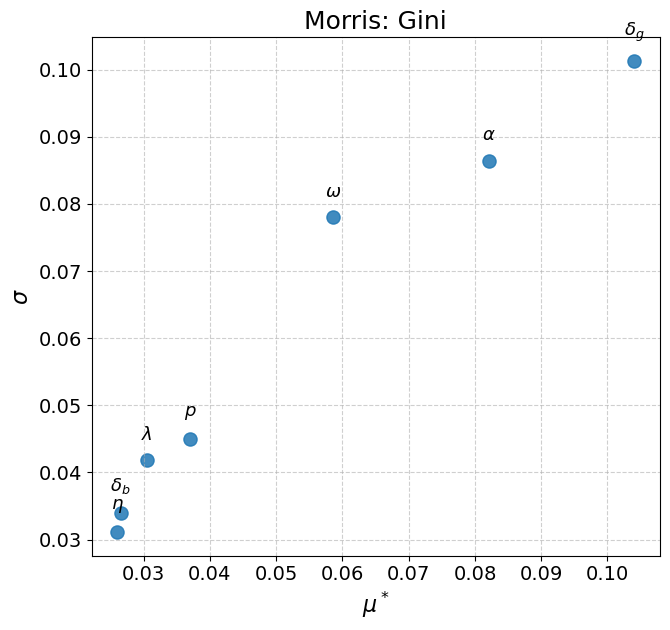

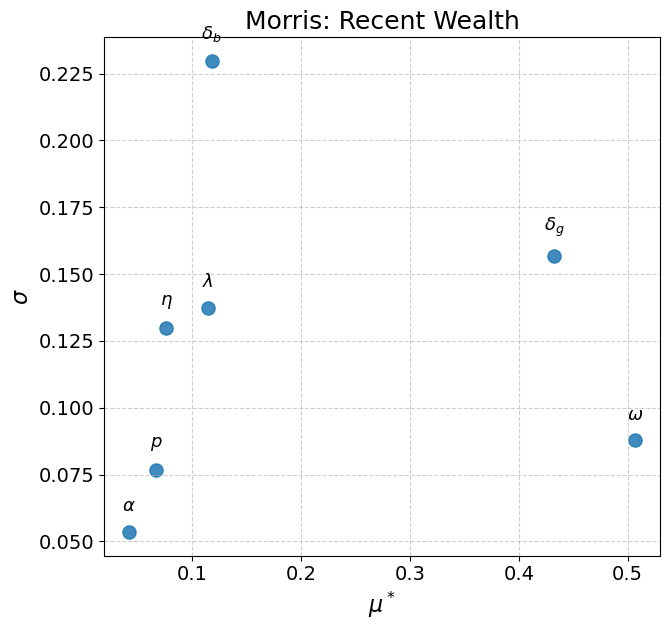

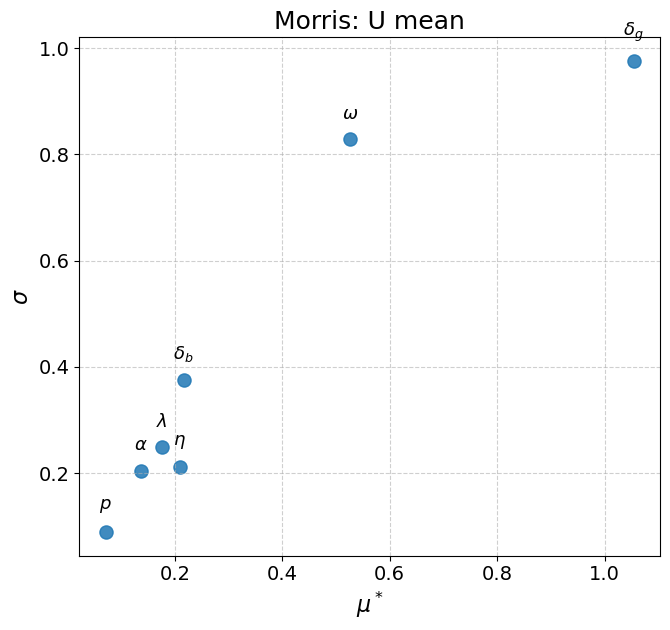

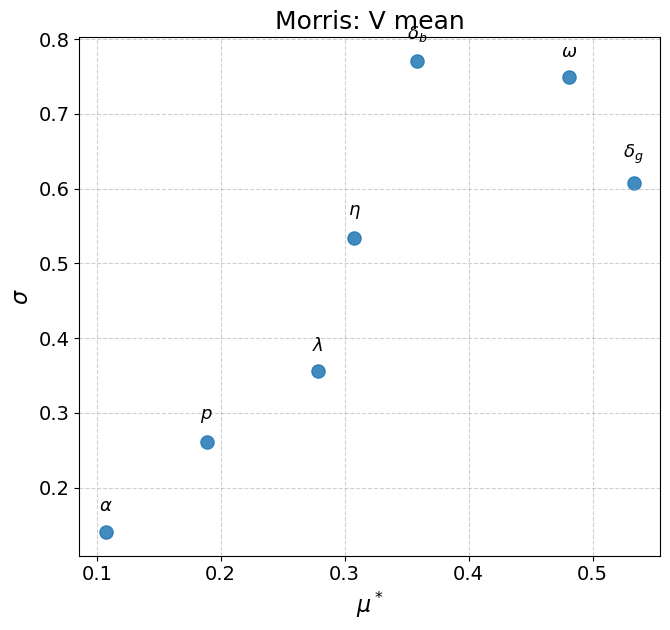

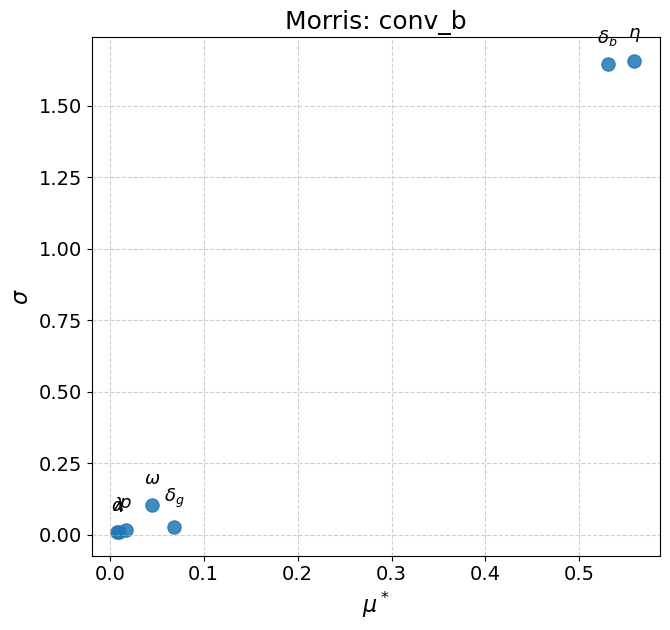

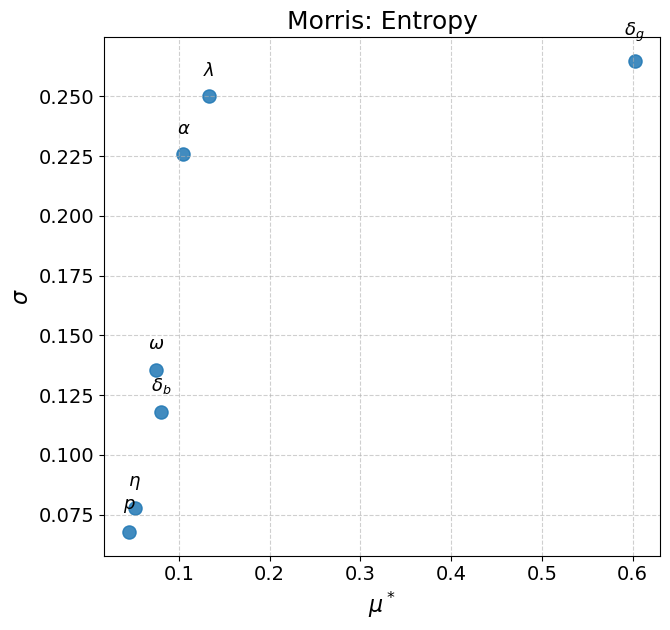

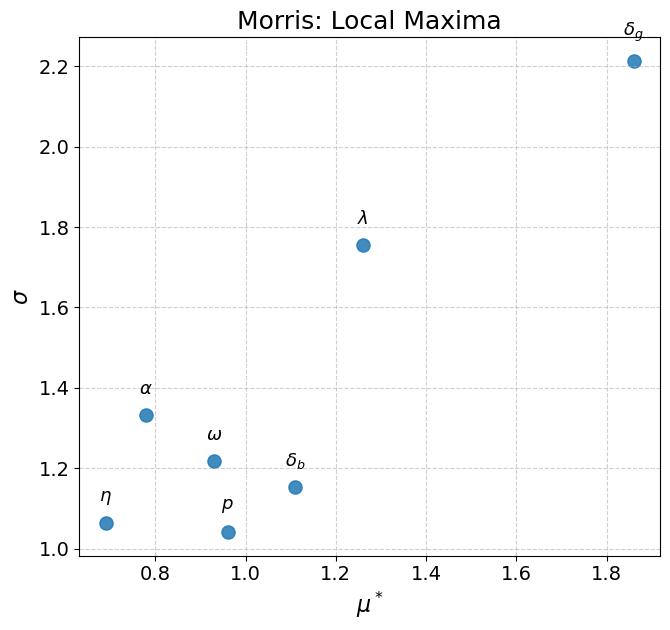

In [6]:
process_and_analyze("Data/")

## Sobol

In [7]:
# Cell 1: imports & helpers

import os, glob, json, ast, math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter, maximum_filter
from SALib.analyze import sobol

# ---------- your helpers (kept as-is) ----------
def extract_uv(series):
    u_vals, v_vals = [], []
    for item in series:
        u, v = np.nan, np.nan
        if isinstance(item, (tuple, list)):
            u, v = item
        elif isinstance(item, str):
            u, v = ast.literal_eval(item)
        if not (math.isnan(u) or math.isnan(v)):
            u_vals.append(float(u))
            v_vals.append(float(v))
    return u_vals, v_vals


def _grid_density(u_vals, v_vals, gridsize=40):
    u_vals = np.asarray(u_vals, dtype=float)
    v_vals = np.asarray(v_vals, dtype=float)
    n = len(u_vals)

    if n < 5 or np.isclose(np.std(u_vals), 0.0) or np.isclose(np.std(v_vals), 0.0):
        H, _, _ = np.histogram2d(u_vals, v_vals, bins=gridsize)
        dens = H / H.sum() if H.sum() > 0 else np.zeros((gridsize, gridsize))
        if H.sum() > 0:
            dens = gaussian_filter(dens, sigma=1.0)
            dens = dens / dens.sum()
        return dens

    try:
        pts = np.vstack([u_vals, v_vals])
        kde = gaussian_kde(pts)
        u_lin = np.linspace(u_vals.min(), u_vals.max(), gridsize)
        v_lin = np.linspace(v_vals.min(), v_vals.max(), gridsize)
        uu, vv = np.meshgrid(u_lin, v_lin, indexing="xy")
        dens = kde(np.vstack([uu.ravel(), vv.ravel()])).reshape(gridsize, gridsize)
        s = dens.sum()
        if s <= 0 or not np.isfinite(s):
            raise RuntimeError("KDE produced non-positive sum")
        return dens / s
    except Exception:
        H, _, _ = np.histogram2d(u_vals, v_vals, bins=gridsize)
        dens = H / H.sum() if H.sum() > 0 else np.zeros((gridsize, gridsize))
        if H.sum() > 0:
            dens = gaussian_filter(dens, sigma=1.0)
            dens = dens / dens.sum()
        return dens


def compute_entropy(u_vals, v_vals, gridsize=40):
    dens2d = _grid_density(u_vals, v_vals, gridsize=gridsize)
    p = dens2d.ravel()
    H = -np.sum(p * np.log(p + 1e-12))
    H_max = np.log(p.size)
    return float(H / H_max) if H_max > 0 else 0.0


def count_local_maxima(u_vals, v_vals, gridsize=40, thr_ratio=0.05):
    dens2d = _grid_density(u_vals, v_vals, gridsize=gridsize)
    dens2d = gaussian_filter(dens2d, sigma=1.0)
    peak_mask = (dens2d == maximum_filter(dens2d, size=3, mode="constant"))
    peak_mask &= dens2d > (dens2d.max() * thr_ratio)
    return int(peak_mask.sum())


def compute_gini(x):
    x = np.array(x)
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    if x_sorted.sum() == 0:
        return 0
    return (np.sum((2 * index - n - 1) * x_sorted)) / (n * np.sum(x_sorted))


def _exp_decay(t, a, b, c):
    return a * np.exp(-b * t) + c


def parse_ug(x):
    if isinstance(x, str):
        return ast.literal_eval(x.replace("np.float64", ""))
    return x


def convergence_rate(ug_series):
    from scipy.optimize import curve_fit
    t = ug_series.index.values.astype(float)
    y = ug_series.values.astype(float)

    tail_n = max(1, len(y) // 10)
    c0 = y[-tail_n:].mean()
    p0 = [max(y[0]-c0, 1e-3), 0.01, c0]

    popt, _ = curve_fit(_exp_decay, t, y, p0=p0, maxfev=10000)
    _, b_fit, _ = popt
    return b_fit
# ---------- end helpers ----------


def find_column(df: pd.DataFrame, targets):
    """Return first matching column (case/space/underscore insensitive)."""
    if isinstance(targets, str):
        targets = [targets]
    normalized = {c: c for c in df.columns}
    def norm(s): return s.strip().lower().replace(" ", "_")
    inv = {norm(c): c for c in df.columns}
    for t in targets:
        key = norm(t)
        if key in inv:
            return inv[key]
    # secondary: try contains-based match
    for t in targets:
        key = norm(t)
        for c in df.columns:
            if norm(c) == key or key in norm(c):
                return c
    raise KeyError(f"None of {targets} found in columns: {list(df.columns)}")


In [8]:
# Cell 2: configuration

BASE_DIR = Path("sobol_GSA")  # change if needed
RAW_DIR = BASE_DIR / "raw_runs"

# metrics to compute & their order (7 columns in Y)
METRIC_LABELS = ["Gini_Wealth", "Recent_wealth", "U_mean", "V_mean", "Conv_b", "Entropy", "Num_Maxima"]

# aggregation across replicates: "mean" or "median"
AGG = "mean"  # or "median"

# which timestep to extract for agent-level snapshot
STEP_MODE = "last"  # "last" or an integer row index

# Sobol problem (must match the Saltelli sample used to generate param_values.csv)
PARAM_NAMES = ["alpha", "rat", "normalize", "dependence_game"]
D = len(PARAM_NAMES)

# load design matrix (Saltelli/Sobol)
X_path = BASE_DIR / "param_values.csv"
assert X_path.exists(), f"Missing {X_path}"
X = np.loadtxt(X_path, delimiter=",")
assert X.shape[1] == D, f"param_values has {X.shape[1]} cols, expected {D} for {PARAM_NAMES}"
N = X.shape[0]

print(f"Loaded design matrix X: shape={X.shape}, D={D}, PARAMS={PARAM_NAMES}")


Loaded design matrix X: shape=(384, 4), D=4, PARAMS=['alpha', 'rat', 'normalize', 'dependence_game']


In [9]:
# Cell 3: build Y (N x 7) by aggregating all reps for each param_idx

def get_last_step_snapshot(agent_df: pd.DataFrame, step_mode="last") -> pd.DataFrame:
    step_col = find_column(agent_df, ["Step"])
    if isinstance(step_mode, str) and step_mode.lower() == "last":
        last_step = agent_df[step_col].max()
        return agent_df[agent_df[step_col] == last_step]
    idx = int(step_mode)
    # treat as positional index
    unique_steps = sorted(agent_df[step_col].unique())
    assert 0 <= idx < len(unique_steps), f"step index {idx} out of range"
    sel_step = unique_steps[idx]
    return agent_df[agent_df[step_col] == sel_step]

def aggregate(vals, how="mean"):
    arr = np.asarray(vals, dtype=float)
    return float(np.mean(arr)) if how == "mean" else float(np.median(arr))

Y = np.zeros((N, 7), dtype=float)
rep_counts = np.zeros(N, dtype=int)

for idx in range(N):
    agent_files = sorted(RAW_DIR.glob(f"agent_data_{idx}_*.csv"))
    model_files = sorted(RAW_DIR.glob(f"model_data_{idx}_*.csv"))
    assert len(agent_files) > 0, f"No agent files for idx={idx}"
    assert len(model_files) > 0, f"No model files for idx={idx}"

    metrics_across_reps = []

    for af in agent_files:
        # match the corresponding model file by rep id
        rep_str = af.stem.split("_")[-1]  # last token is rep
        mf = RAW_DIR / f"model_data_{idx}_{rep_str}.csv"
        assert mf.exists(), f"Missing model file: {mf}"

        agent_df = pd.read_csv(af)
        model_df = pd.read_csv(mf)

        snap = get_last_step_snapshot(agent_df, step_mode=STEP_MODE)

        # U/V stats from UV column
        uv_col = find_column(snap, ["UV"])
        u_vals, v_vals = extract_uv(snap[uv_col])

        # metrics (agent-level snapshot)
        wealth_col = find_column(snap, ["Wealth"])
        rw_col = find_column(snap, ["Recent Wealth", "Recent_wealth", "recent_wealth", "recent wealth"])
        gini_wealth = compute_gini(snap[wealth_col].values)
        recent_wealth = float(np.mean(snap[rw_col].values))

        u_mean = float(np.nanmean(u_vals)) if len(u_vals) else np.nan
        v_mean = float(np.nanmean(v_vals)) if len(v_vals) else np.nan
        ent = compute_entropy(u_vals, v_vals)
        n_max = count_local_maxima(u_vals, v_vals)

        # Conv_b from model-level time series of |Unique Games|
        ug_col = find_column(model_df, ["Unique Games", "unique_games"])
        model_df = model_df.copy()
        model_df["UG_len"] = model_df[ug_col].apply(lambda x: len(parse_ug(x)))
        step_model_col = find_column(model_df, ["Step"])
        ug_series = model_df.set_index(step_model_col)["UG_len"].sort_index()
        conv_b = float(convergence_rate(ug_series))

        metrics_across_reps.append([
            gini_wealth, recent_wealth, u_mean, v_mean, conv_b, ent, n_max
        ])

    rep_counts[idx] = len(metrics_across_reps)
    arr = np.array(metrics_across_reps, dtype=float)
    if AGG == "mean":
        Y[idx, :] = np.nanmean(arr, axis=0)
    else:
        Y[idx, :] = np.nanmedian(arr, axis=0)

assert Y.shape == (N, 7)
print(f"Built Y with shape {Y.shape}. Avg reps per design point: {rep_counts.mean():.2f}")


/var/folders/88/y5fnr9x56fb7r2mnf9z_qd1w0000gn/T/ipykernel_32455/174116091.py:91: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * t) + c
/var/folders/88/y5fnr9x56fb7r2mnf9z_qd1w0000gn/T/ipykernel_32455/174116091.py:91: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * t) + c


Built Y with shape (384, 7). Avg reps per design point: 3.00


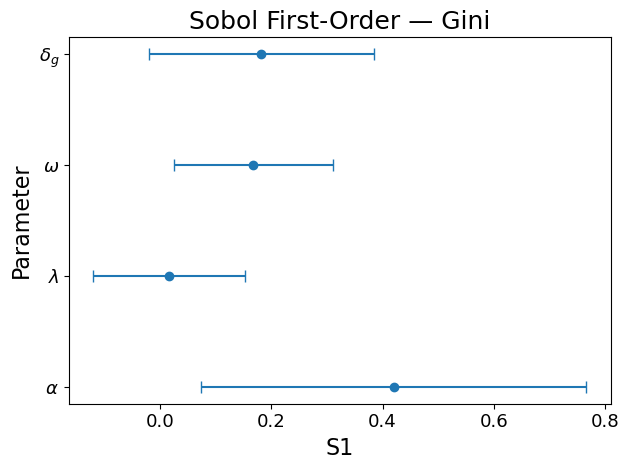

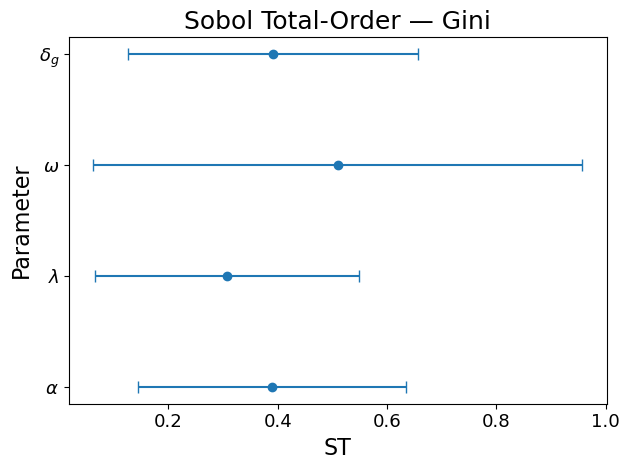

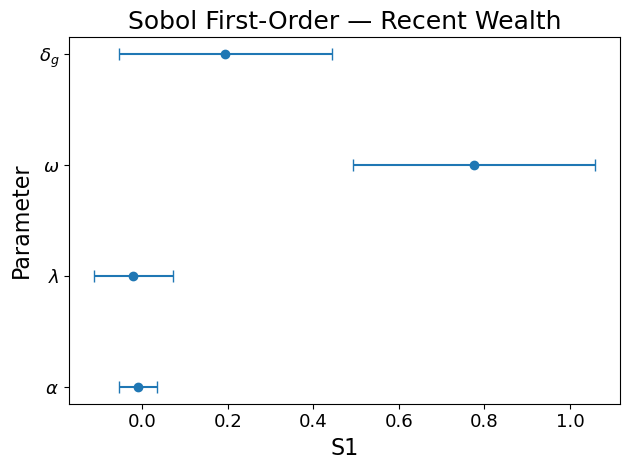

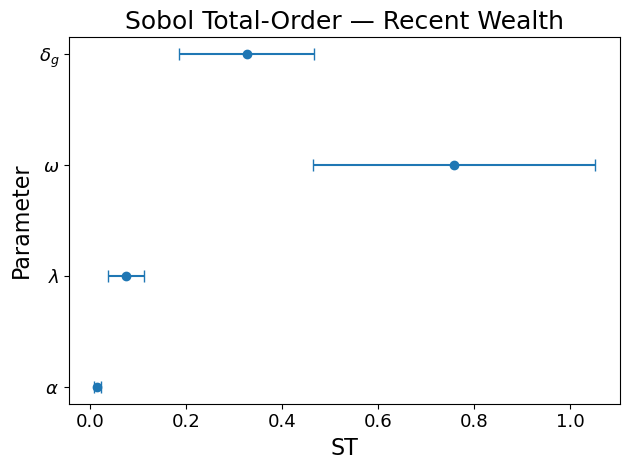

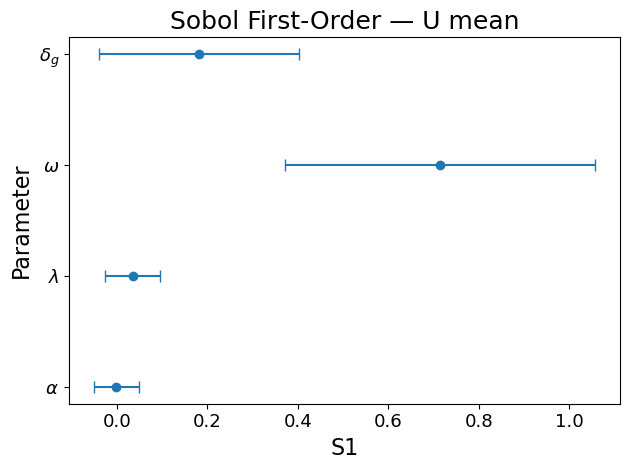

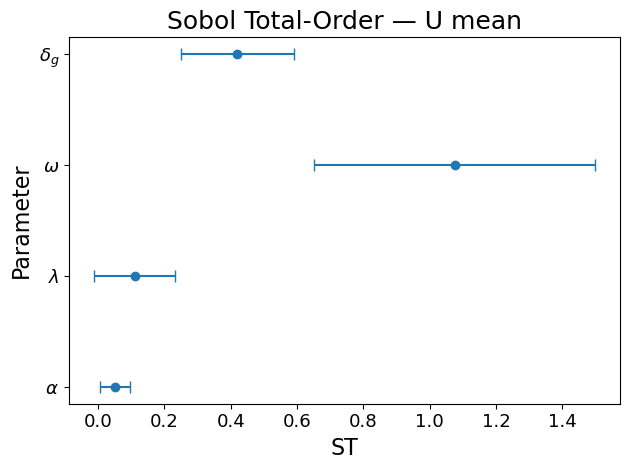

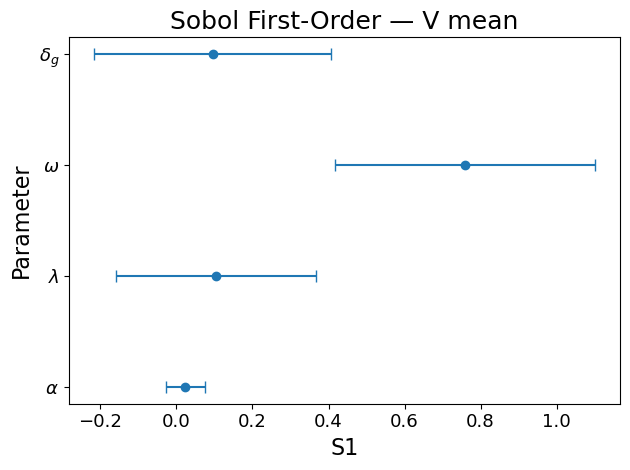

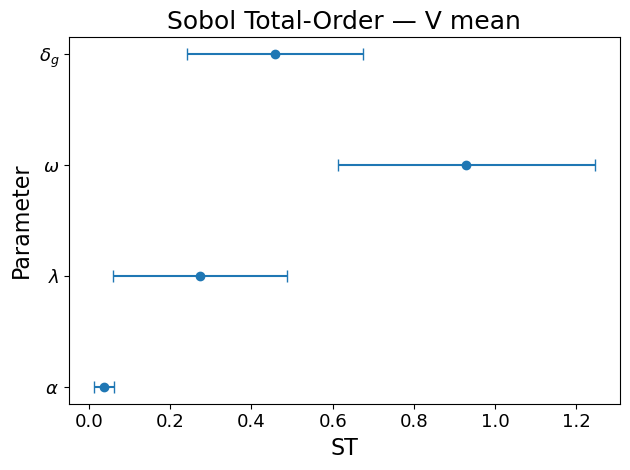

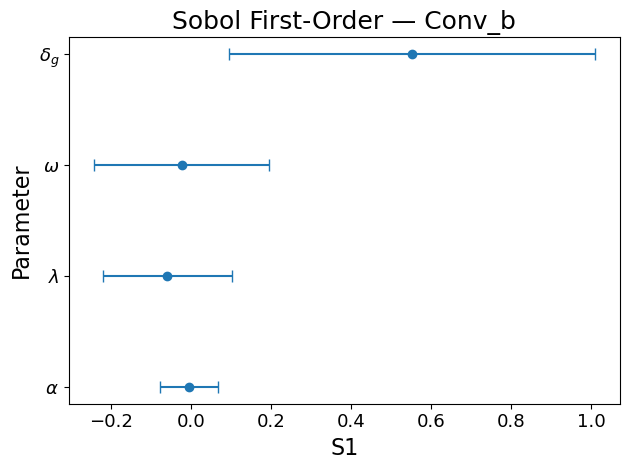

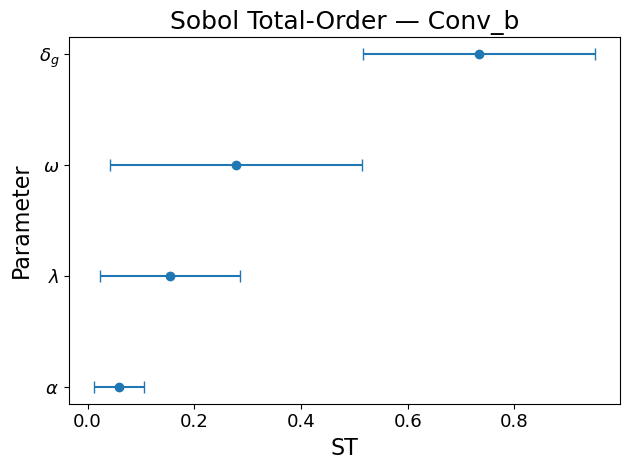

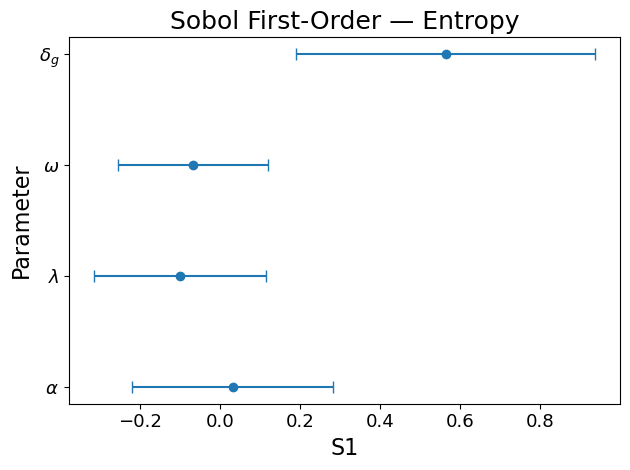

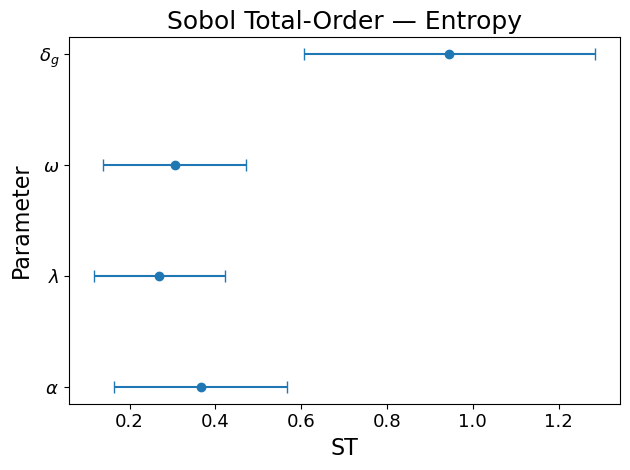

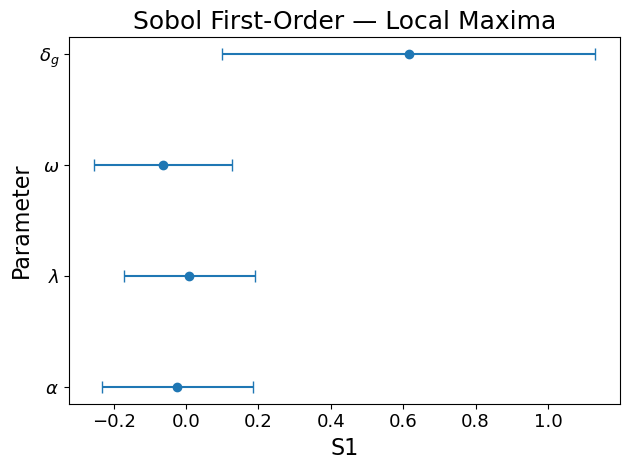

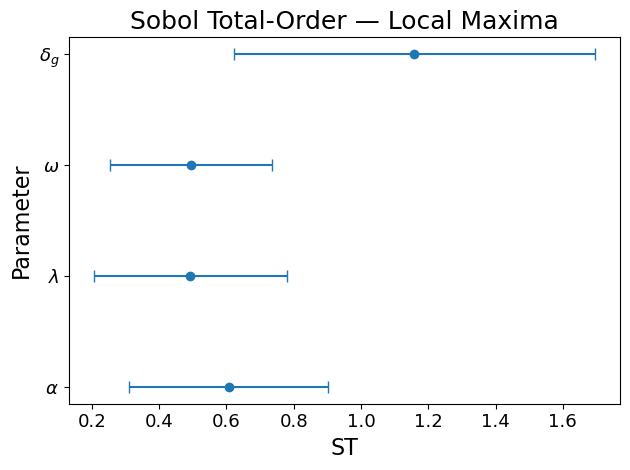

In [11]:
# Cell 4: Sobol analyze (S1 & ST) for each metric column, save CSV and plots

problem = {
    "num_vars": D,
    "names": PARAM_NAMES,
    "bounds": [[0, 1]] * D,  # not used by analyze but required by API
}

label_display = {
    "Gini_Wealth": "Gini",
    "Recent_wealth": "Recent Wealth",
    "Num_Maxima": "Local Maxima",
    "U_mean": "U mean",
    "V_mean": "V mean",
}
param_display_map = {
    "alpha": r"$\alpha$",
    "rat": r"$\lambda$",
    "normalize": r"$\omega$",
    "dependence_game": r"$\delta_g$",
}


SAVE = True  # set False if you don't want files written

results = {}

for k, label in enumerate(METRIC_LABELS):
    y = Y[:, k]
    # SALib expects y aligned with Saltelli matrix (already true)
    Si = sobol.analyze(problem, y, calc_second_order=False, print_to_console=False)

    df = pd.DataFrame({
        "parameter": PARAM_NAMES,
        "S1": Si["S1"],
        "S1_conf": Si["S1_conf"],
        "ST": Si["ST"],
        "ST_conf": Si["ST_conf"],
    })
    results[label] = df

    display(df.style.format({"S1":"{:.3f}","S1_conf":"{:.3f}","ST":"{:.3f}","ST_conf":"{:.3f}"}))

    title_label = label_display.get(label, label)
    y_labels = [param_display_map.get(p, p) for p in df["parameter"]]
    y_pos = np.arange(len(y_labels))

    plt.figure()
    plt.errorbar(df["S1"].values, y_pos, xerr=df["S1_conf"].values, fmt="o", capsize=4)
    plt.xlabel("S1", fontsize=16)
    plt.ylabel("Parameter", fontsize=16)
    plt.title(f"Sobol First-Order — {title_label}", fontsize=18)
    plt.yticks(y_pos, y_labels, fontsize=13)
    plt.xticks(fontsize=13)
    plt.tight_layout()
    if SAVE:
        out_png = BASE_DIR / f"sobol_S1_{label.lower()}.png"
        plt.savefig(out_png, dpi=150)
    plt.show()

    # Plot ST as horizontal dot with error bars
    plt.figure()
    plt.errorbar(df["ST"].values, y_pos, xerr=df["ST_conf"].values, fmt="o", capsize=4)
    plt.xlabel("ST", fontsize=16)
    plt.ylabel("Parameter", fontsize=16)
    plt.title(f"Sobol Total-Order — {title_label}", fontsize=18)
    plt.yticks(y_pos, y_labels, fontsize=13)
    plt.xticks(fontsize=13)
    plt.tight_layout()
    if SAVE:
        out_png = BASE_DIR / f"sobol_ST_{label.lower()}.png"
        plt.savefig(out_png, dpi=150)
    plt.show()

## Ratio

In [20]:
import re
import os
import ast
import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Simulate
from datetime import datetime
from scipy.optimize import curve_fit

/Users/sunsunsun/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/sunsunsun/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/sunsunsun/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/sunsunsun/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/sunsunsun/anaconda3/lib/python3.11/site-packages/scipy/optimize/_

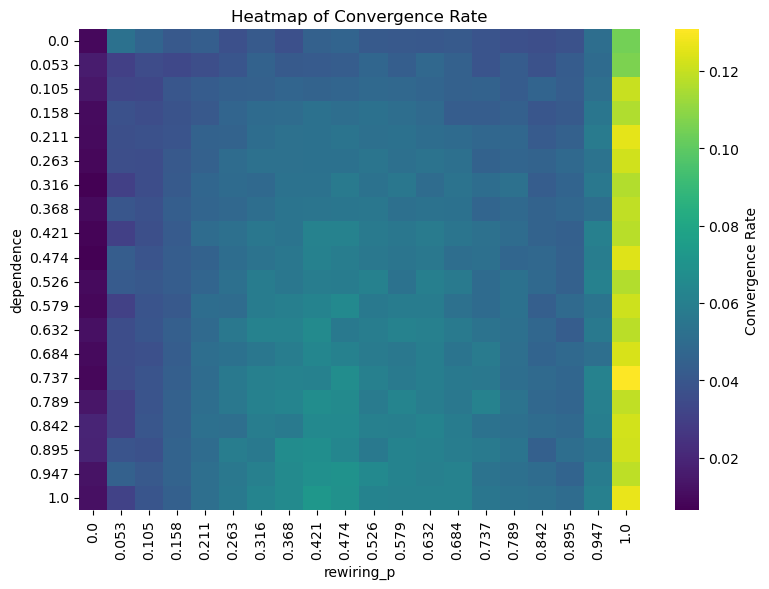

In [21]:
def parse_ug(s):
    if isinstance(s, str):
        return len(ast.literal_eval(s))
    elif isinstance(s, list):
        return len(s)
    else:
        return 0

def ug_series(df):
    d = df.copy()
    d["UG_left"] = d["Unique Games"].apply(parse_ug)
    return d.set_index("Step")["UG_left"]

def exp_decay(t, a, b, c):
    return a * np.exp(-b * t) + c

def mean_b_table(data_dir="Data/uv_and_rewiring"):
    pat = re.compile(r"model_data_(\d+\.\d+)_(\d+\.\d+)_")
    bag = {}

    for f in glob.glob(os.path.join(data_dir, "model_data_*.csv")):
        m = pat.search(os.path.basename(f))

        p = float(m.group(1))
        dep = float(m.group(2))

        series = ug_series(pd.read_csv(f))

        t = series.index.values
        y = series.values

        c0 = y[-5:].mean()
        p0 = [y[0] - c0, 0.01, c0]
        popt, _ = curve_fit(exp_decay, t, y, p0, maxfev=10000)
        _, b, _ = popt

        bag.setdefault((p, dep), []).append(b)

    rows = [
        {"rewiring_p": k[0], "dependence": k[1], "b": np.mean(v)}
        for k, v in bag.items()
    ]
    df = pd.DataFrame(rows)
    return df.pivot(index="dependence", columns="rewiring_p", values="b").sort_index().sort_index(axis=1)

def plot_b_heatmap(data_dir="Data/uv_and_rewiring", outname="convergence_heatmap.png"):
    table = mean_b_table(data_dir)
    plt.figure(figsize=(8,6))
    sns.heatmap(table, cmap="viridis", annot=False, fmt=".3f",
                cbar_kws={'label': 'Convergence Rate'})
    plt.title("Heatmap of Convergence Rate")
    plt.xlabel("rewiring_p")
    plt.ylabel("dependence")
    plt.tight_layout()
    plt.savefig(outname, dpi=150)

plot_b_heatmap(data_dir="Data/ratio", outname="convergence_heatmap.png")